# EMPIRICAL DATA ANALYSIS

In questa sezione sono raccolte analisi preliminari su Industrial Production (IP) complessiva di UE27 (indice IPI preso da Eurostat, 2015 = 100) e Gas Price (GP). 

Più precisamente, ho fatto:
- Plot delle medie e varianze
- Seasonal decomposition
- Analisi delle distribuzioni e test della normalità
- Test di correlazione
- Stima di un modello ARIMA per IP
- Test di cointegrazione tra IP e GP
- Test per la presenza di structural break nelle variabili

Tutte le funzioni con loro rispettive spiegazioni sono nel file utils.py

In [94]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
#import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl
from scipy import stats
import warnings
from chow_test import chow_test

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

from utils import plot_rolling_variance, plot_rolling_mean,  analyze_order, find_best_model, ljung_box_test, fit_arima_models, jcitest, egcitest, ts_decomposition, gctest



In [2]:
os.chdir('C:\\Users\\loren\\OneDrive\\Desktop\\PhD\\Progetto\\python\\')
path = 'data'

In [3]:
df = pd.read_csv(os.path.join(path, "sample_df.csv"))

In [4]:
df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m")

df = df.rename(columns={"OBS_VALUE": "IP"})

In [5]:
df.set_index('Time', inplace=True)

## Plot

La produzione industriale a livello europeo sembra seguire un trend crescente nel corso degli anni. Tuttavia, si nota come la crisi finanziaria (GFC) e il covid abbiamo impattato negativamente sul livello della produzione e si possono notare, infatti, due picchi negativi in presenza delle citate crisi. La produzione non sembra oltretutto influenzata particolarmente dall'inizio dell'invasione dell'Ucraina.

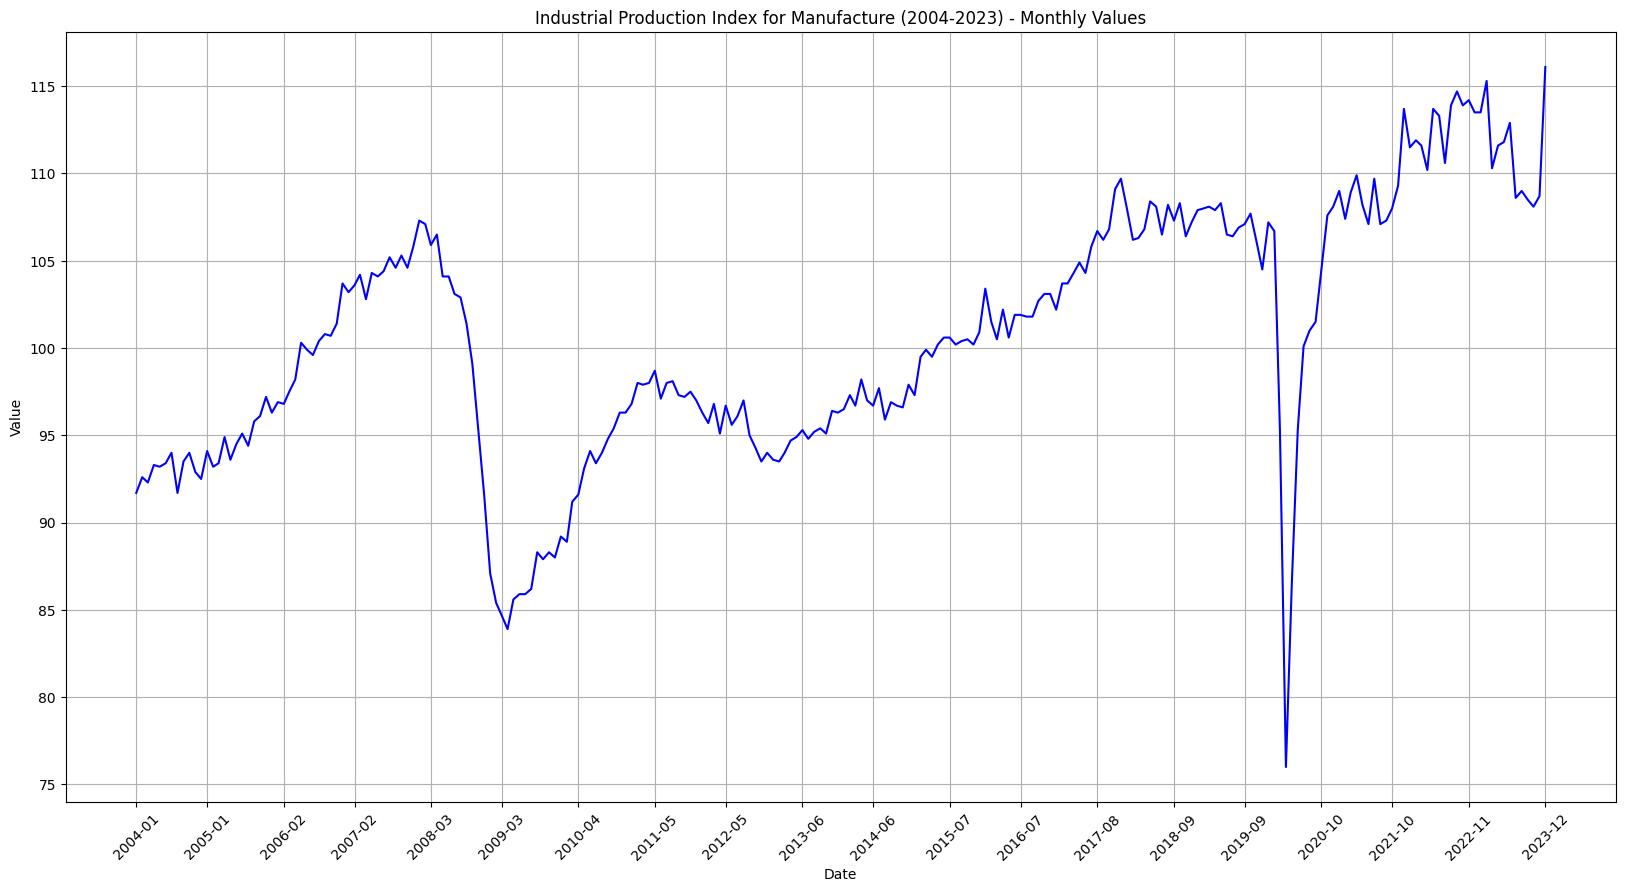

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.index, df['IP'], label = 'IP Value', color = 'Blue')
# Set custom x-ticks to show fewer labels
tick_indices = np.linspace(0, len(df.index)-1, 20, dtype=int)  # 10 labels
ax.set_xticks(df.index[tick_indices])
ax.set_xticklabels(df.index[tick_indices].strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Industrial Production Index for Manufacture (2004-2023) - Monthly Values')
plt.grid(True)
plt.show()

Al contrario di IP, i prezzi del gas (GP), calcolati su media mensile, sono influenzati dalla GFC in magnitudine minore. Iniziano a crescere dalla fine del 2021 superando quote di 50 euro per MWh e dall'inizio dell'invasione dell'Ucraina subiscono un'impennata con punte di oltre 200 euro per MWh.

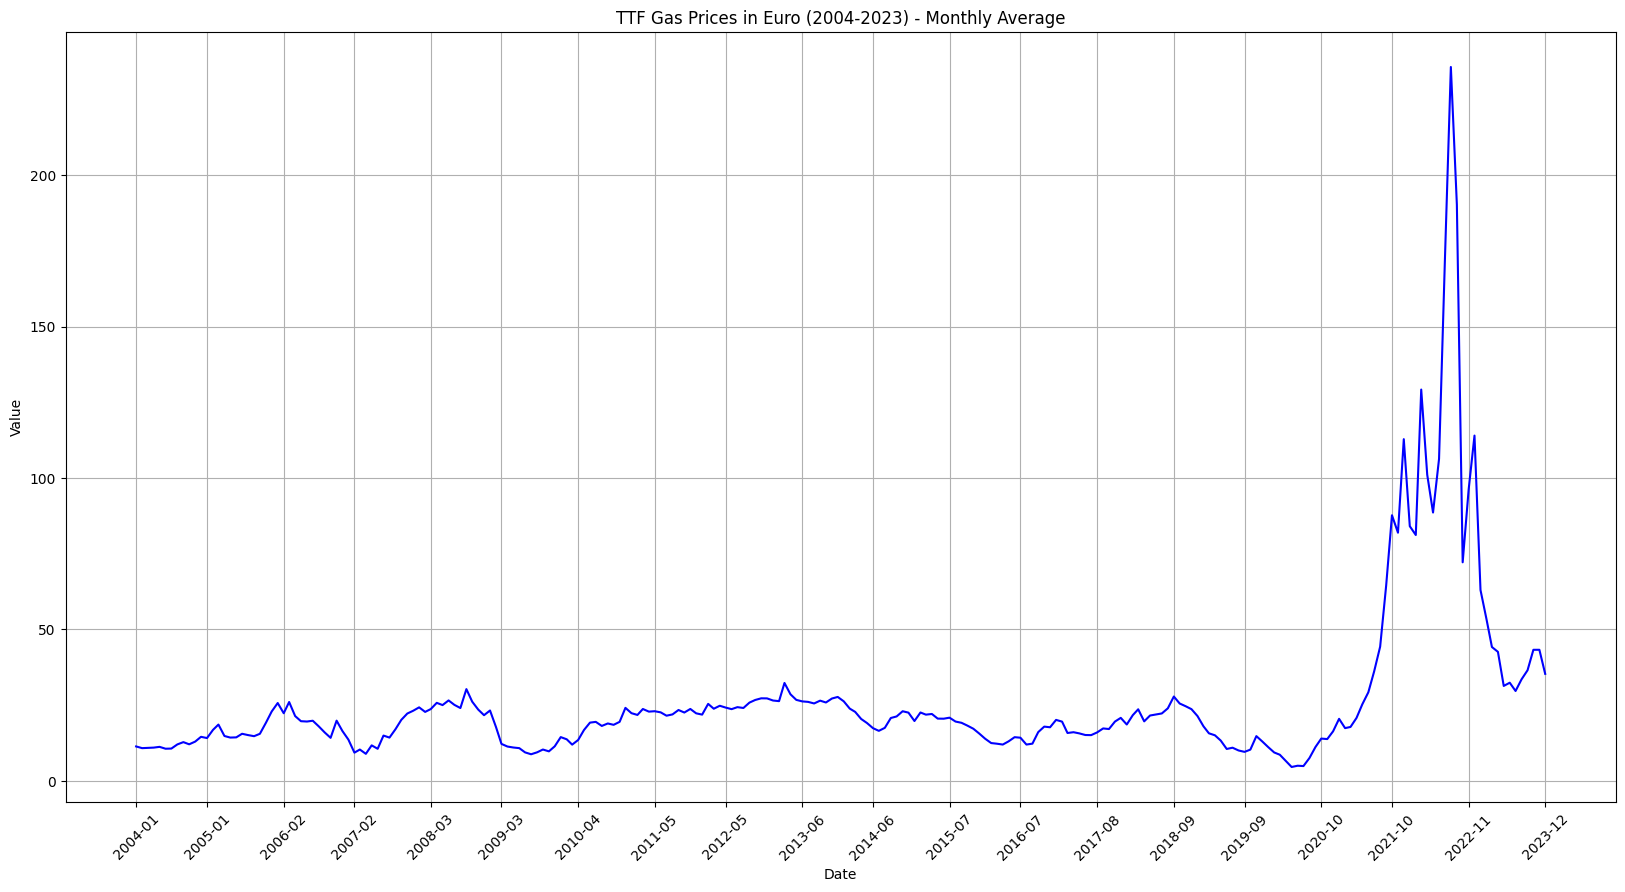

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax.plot(df.index, df['OBS_VALUE'], label = 'IP Value', color = 'Blue')
ax.plot(df.index, df['GAS_PRICE'], label = 'Gas Price', color = 'Blue')

# Set custom x-ticks to show fewer labels
tick_indices = np.linspace(0, len(df.index)-1, 20, dtype=int)  # 10 labels
ax.set_xticks(df.index[tick_indices])
ax.set_xticklabels(df.index[tick_indices].strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('TTF Gas Prices in Euro (2004-2023) - Monthly Average')
plt.grid(True)
plt.show()

In [8]:
df = df.reset_index()

## Media e Varianza rolling

Ho creato due funzioni per identificare e rappresentare media e varianza tramite finestre mobili.  

IP
- La media mensile e trimestrale seguono un trend crescente 

GP

<Axes: xlabel='Time'>

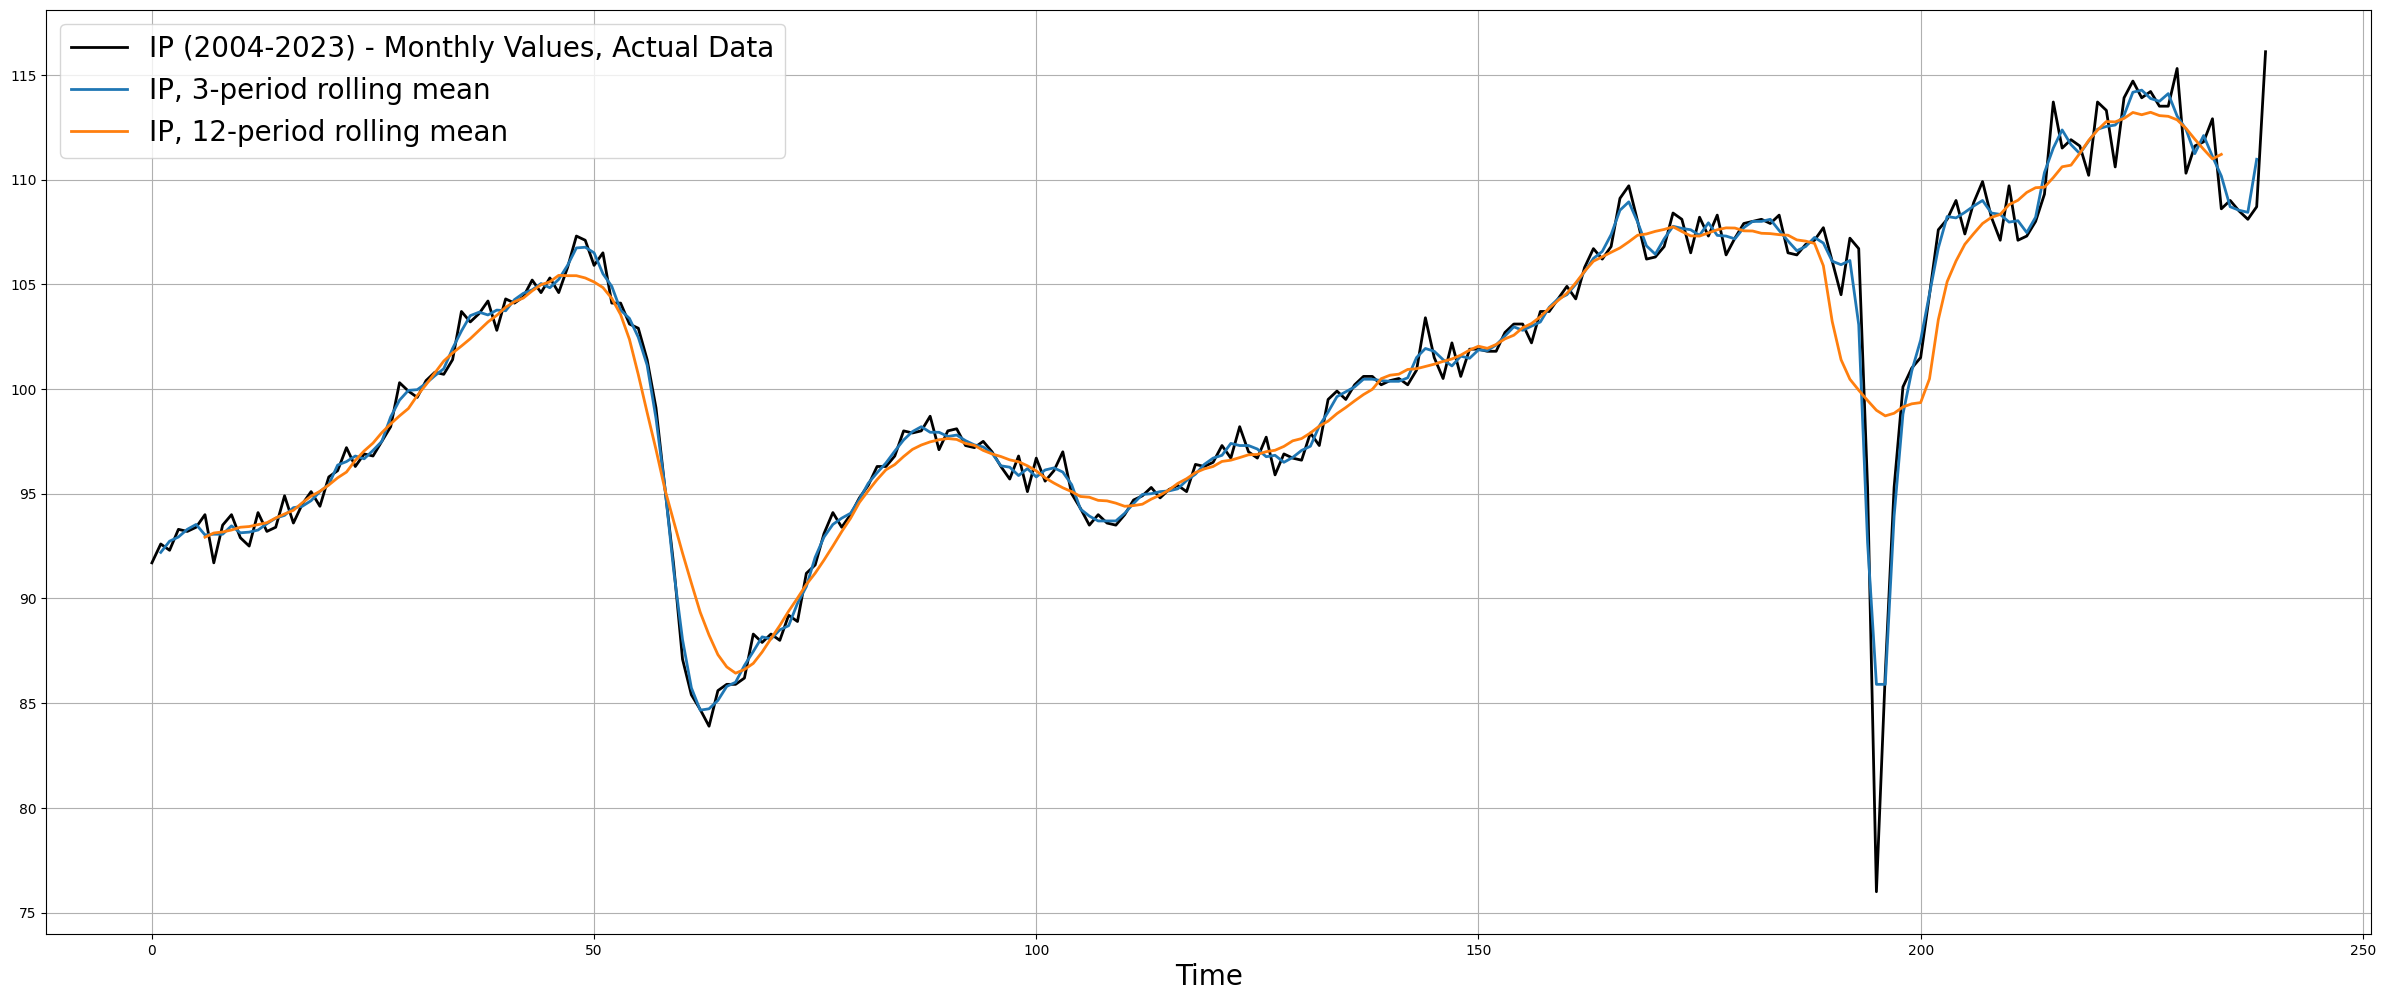

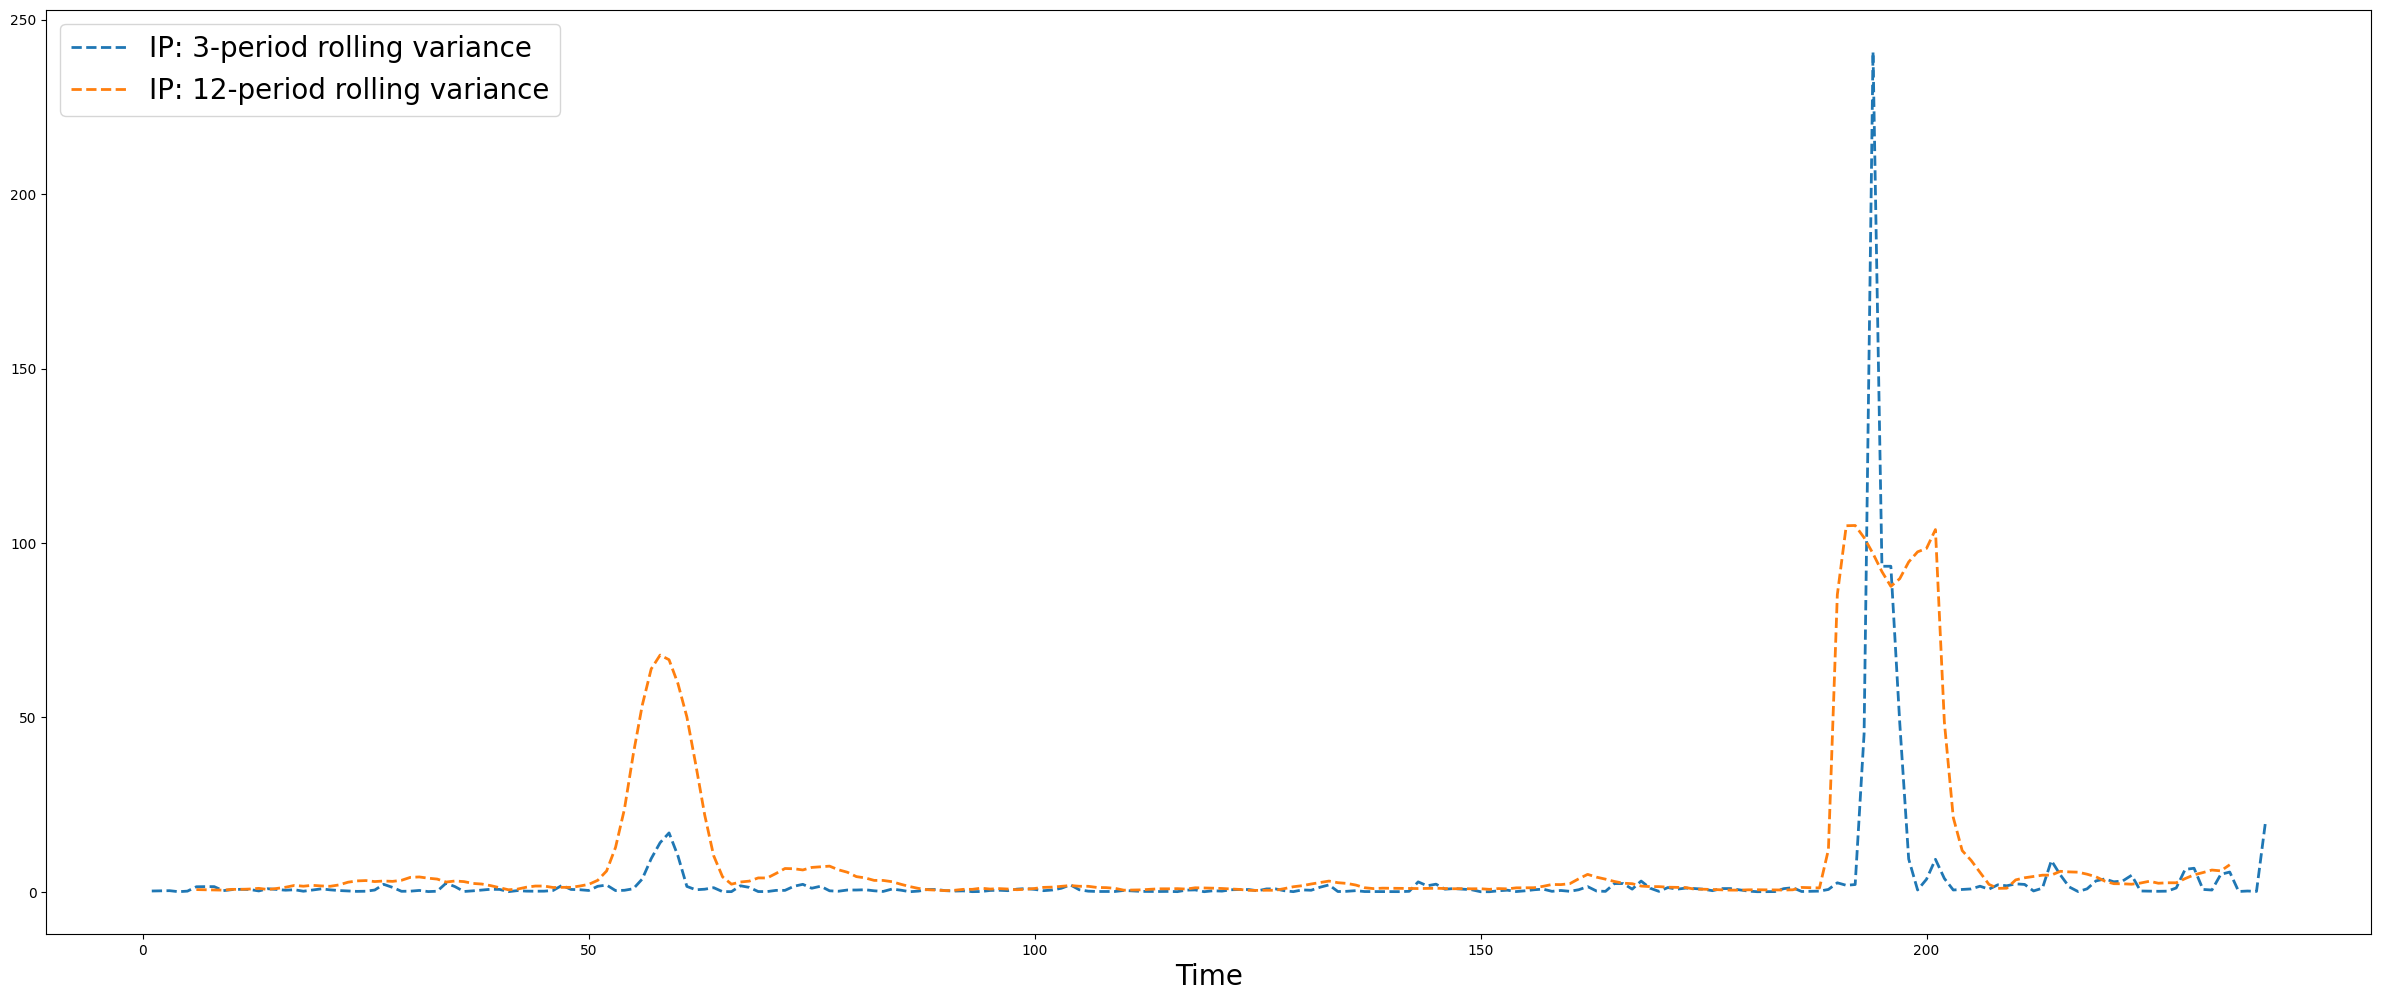

In [9]:
plot_rolling_mean(df, 'IP', [3,12], ylabel=None, title=None, start=0, end=None)
plot_rolling_variance(df, 'IP', [3,12], ylabel=None, title=None, start=0, end=None)

<Axes: xlabel='Time'>

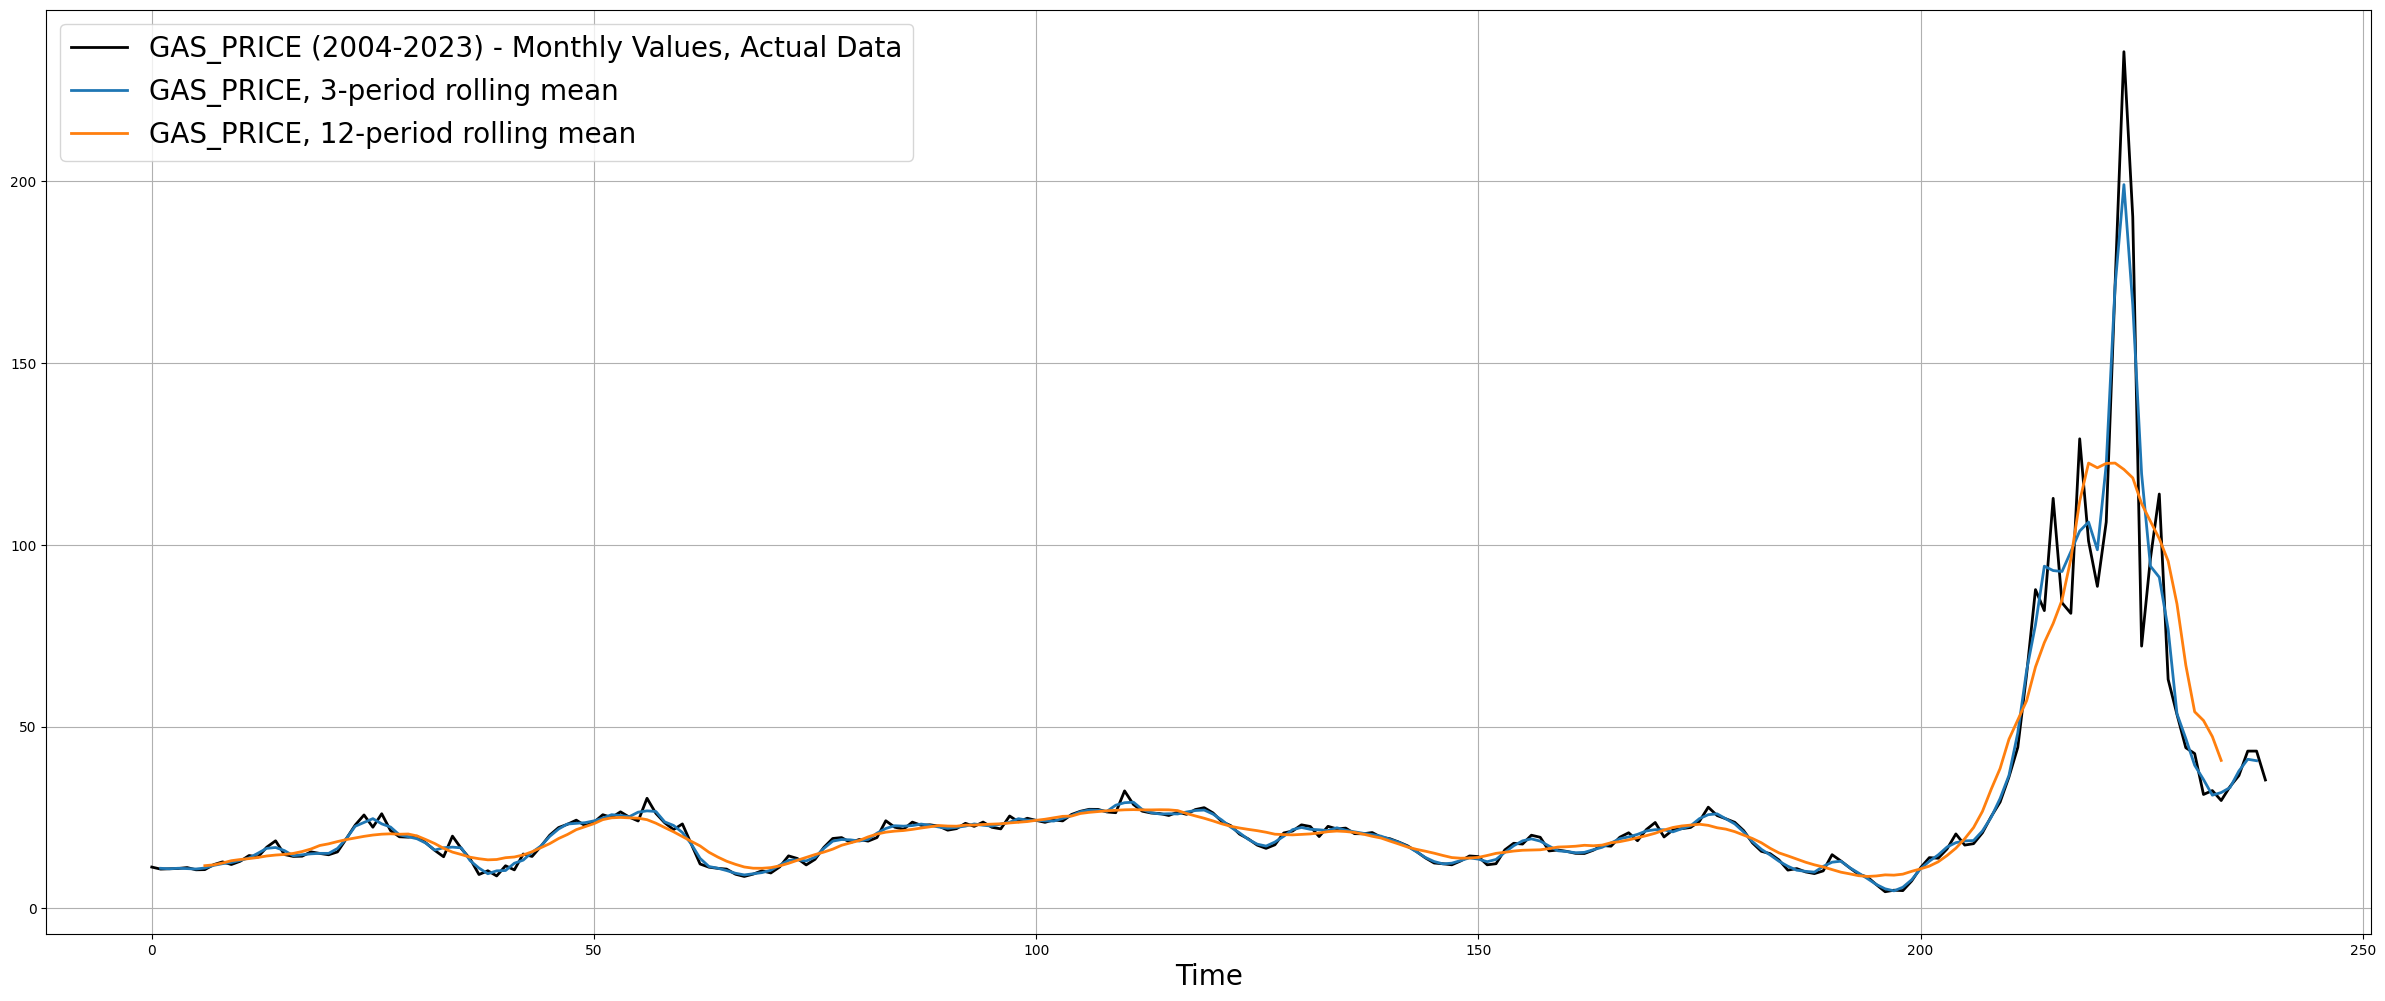

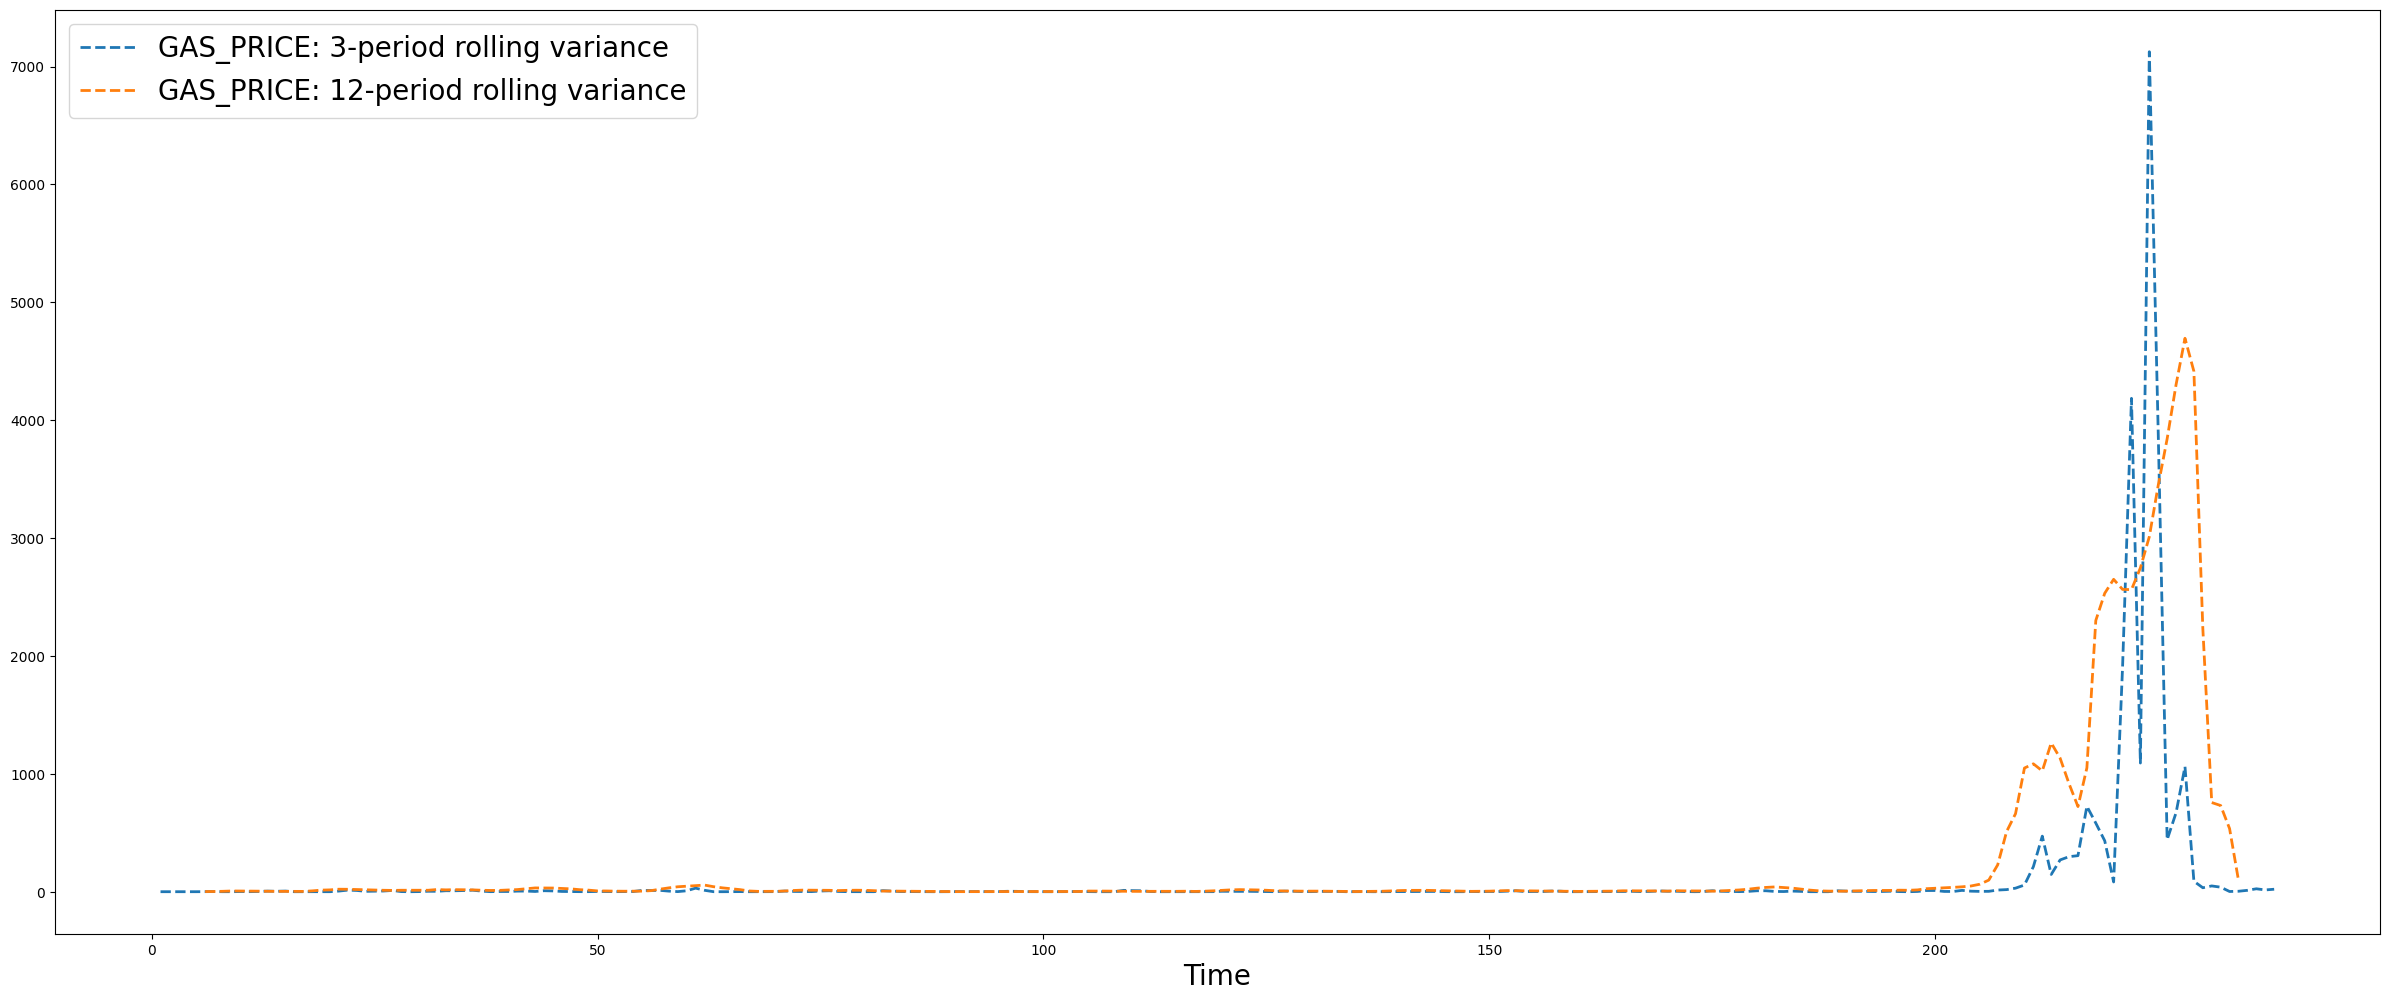

In [10]:
plot_rolling_mean(df, 'GAS_PRICE', [3,12], ylabel=None, title=None, start=0, end=None)
plot_rolling_variance(df, 'GAS_PRICE', [3,12], ylabel=None, title=None, start=0, end=None)

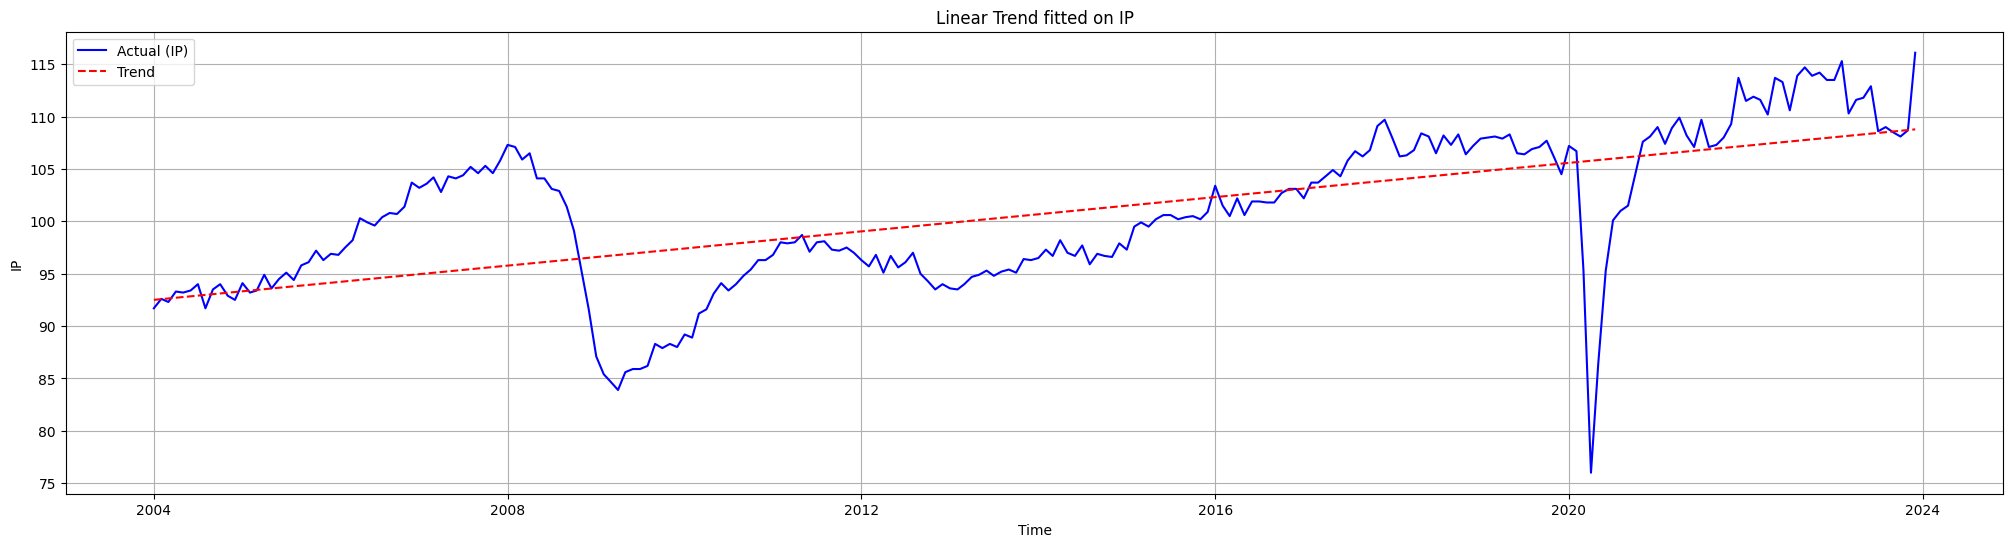

In [11]:
y = df['IP']  # Variabile dipendente
t = range(len(df))  # Variabile indipendente (tempo)

X = sm.add_constant(t)  # costante per intercetta
model = sm.OLS(y, X).fit()

# Valori stimati dal modello
df['IP_trend'] = model.predict(X)

# Plot dei valori reali e del trend stimato
plt.figure(figsize=(25, 6))
plt.plot(df['Time'], df['IP'], label='Actual (IP)', color='blue')
plt.plot(df['Time'], df['IP_trend'], label='Trend', color='red', linestyle='--')
plt.title('Linear Trend fitted on IP')
plt.xlabel('Time')
plt.ylabel('IP')
plt.legend()
plt.grid(True)
plt.show()

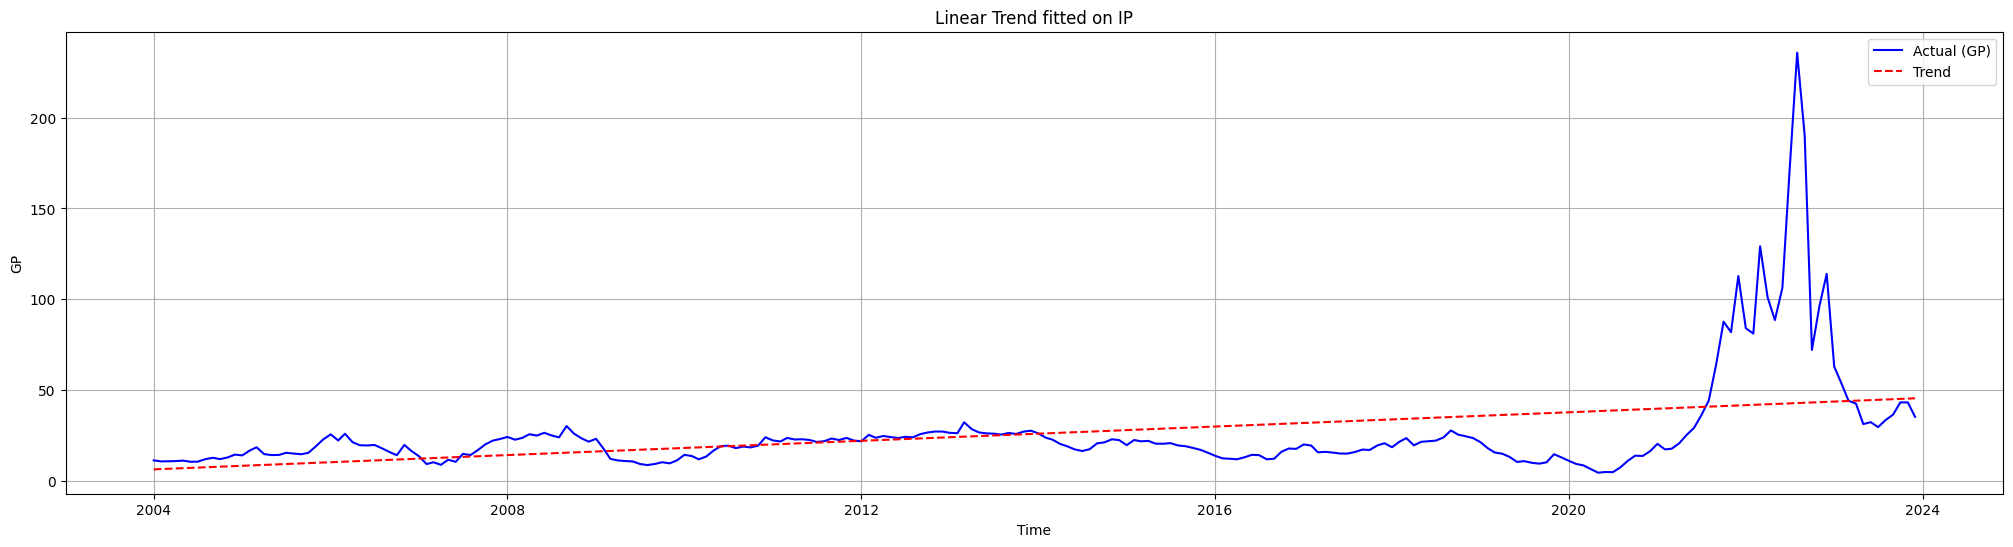

In [12]:
y2 = df['GAS_PRICE']  # Variabile dipendente
t2 = range(len(df))  # Variabile indipendente (tempo)

# Aggiungi un termine costante per la regressione lineare
X2 = sm.add_constant(t)  # Aggiunge un termine costante per intercetta
model2 = sm.OLS(y2, X2).fit()  # Adatta il modello lineare ai dati

# Valori stimati dal modello
df['GAS_PRICE_trend'] = model2.predict(X2)

# Plot dei valori reali e del trend stimato
plt.figure(figsize=(25, 6))
plt.plot(df['Time'], df['GAS_PRICE'], label='Actual (GP)', color='blue')
plt.plot(df['Time'], df['GAS_PRICE_trend'], label='Trend', color='red', linestyle='--')
plt.title('Linear Trend fitted on IP')
plt.xlabel('Time')
plt.ylabel('GP')
plt.legend()
plt.grid(True)
plt.show()

## Seasonal Decomposition

La seasonal decomposition è stata effettuata con la funzione "seasonal_decompose" di python. La funzione richiede tre argomenti:
- La serie storica da analizzare
- il metodo per identificare un eventuale trend. ho impostato due tipi di trend: 
- La finestra di tempo per la seasonal decomposition (1 = annual, 4 = quarterly, 12 = monthly, 365 = daily etc). Ho scelto di confrontare la decomposizione per periodi annuali, trimestrali e mensili. 

La funzione riporta 4 plot per la serie storica analizzata:
- La serie storica "raw", cioé il normale plot della serie.
- Stagionalità
- Trend ricavati da rolling mean di 
- Residui dovuti alla rimozione di trend e stagionalità

Dalle analisi appare che a livello annuale, sia per IP che per GP



Using Moving Average:


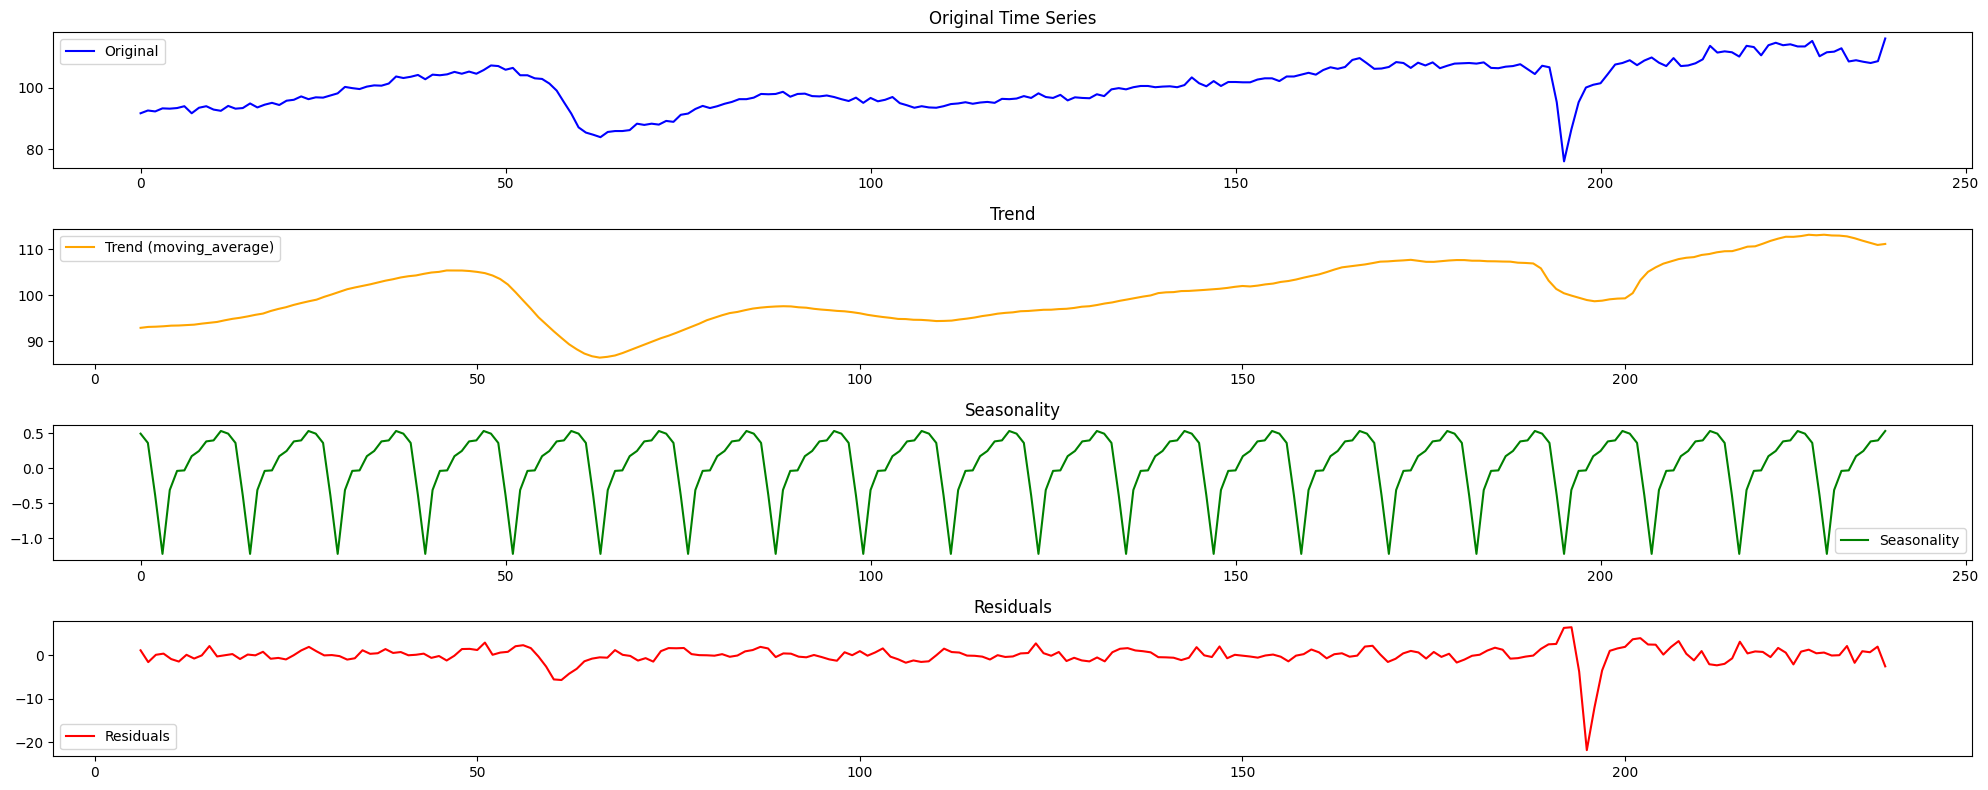

In [13]:
print("Using Moving Average:")
components_ma_ip = ts_decomposition(df['IP'], period=12, trend_method="moving_average")

In [14]:
#components_poly_ip = ts_decomposition(df['IP'], period=12, trend_method="polynomial", poly_degree=2)

Using Moving Average:


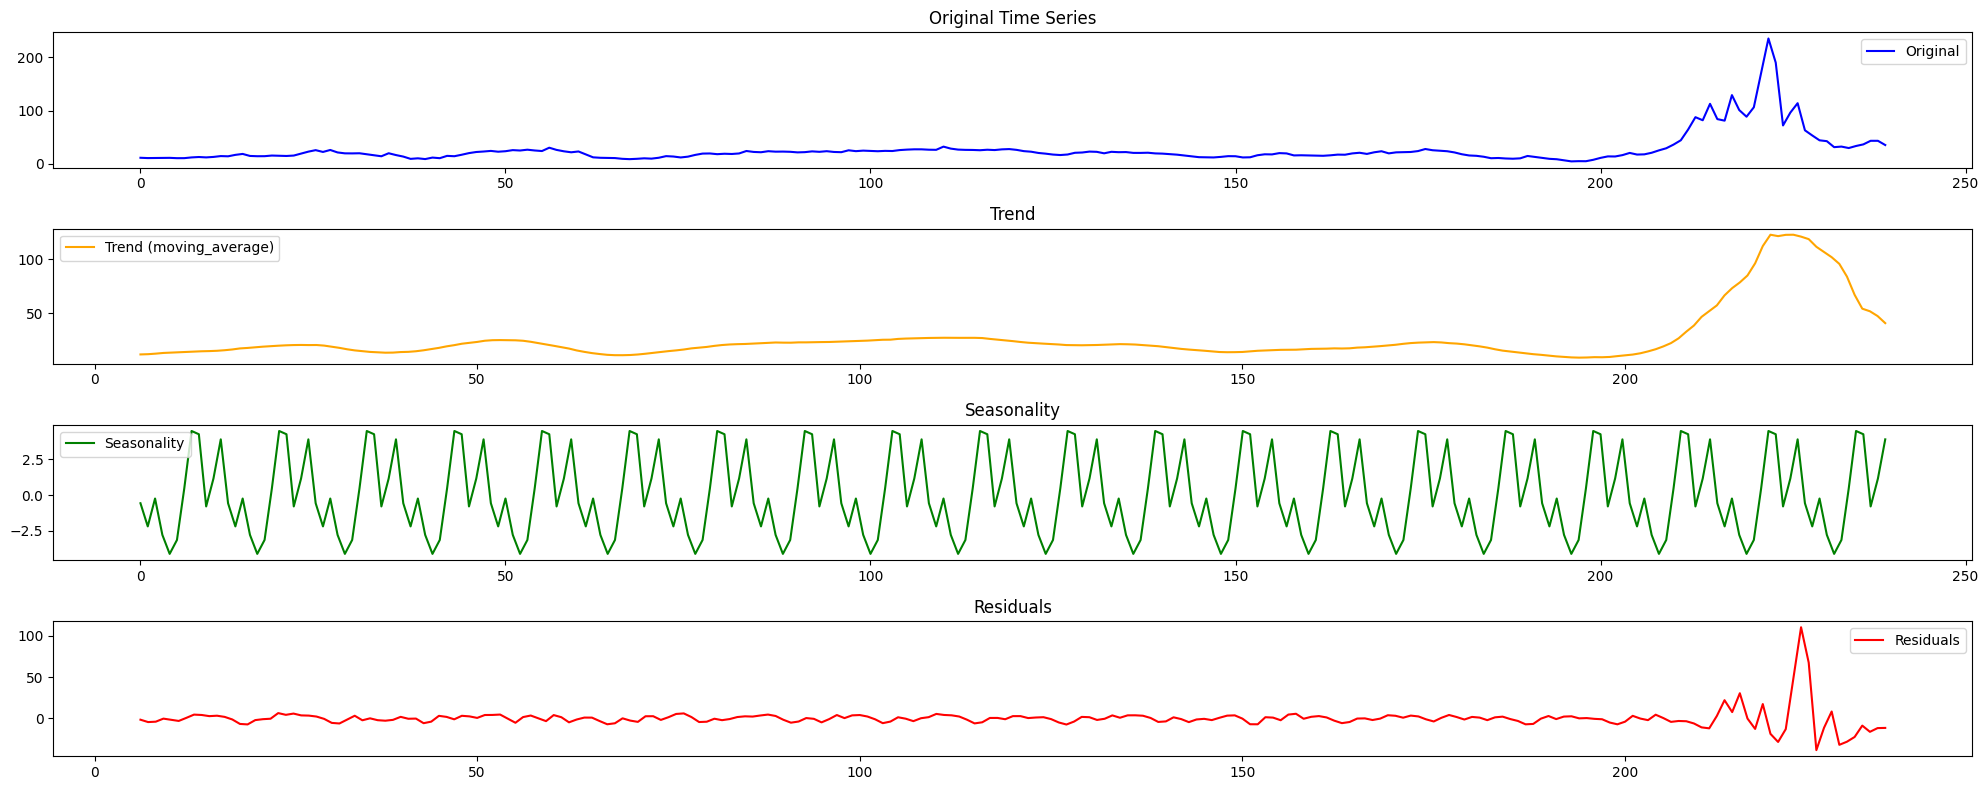

In [15]:
print("Using Moving Average:")
components_ma_gp = ts_decomposition(df['GAS_PRICE'], period=12, trend_method="moving_average")

In [16]:
#components_poly_gp = ts_decomposition(df['GAS_PRICE'], period=12, trend_method="polynomial", poly_degree=1)

In [17]:
shapiro_ip = stats.shapiro(df.IP)
print(shapiro_ip.statistic, shapiro_ip.pvalue)

0.9820492276568733 0.003936813502513107


In [18]:
shapiro_gp = stats.shapiro(df.GAS_PRICE)
print(shapiro_gp.statistic, shapiro_gp.pvalue)

0.5003656713560726 1.51707562653176e-25


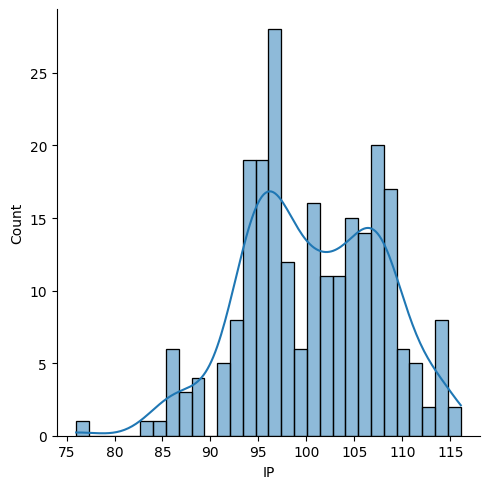

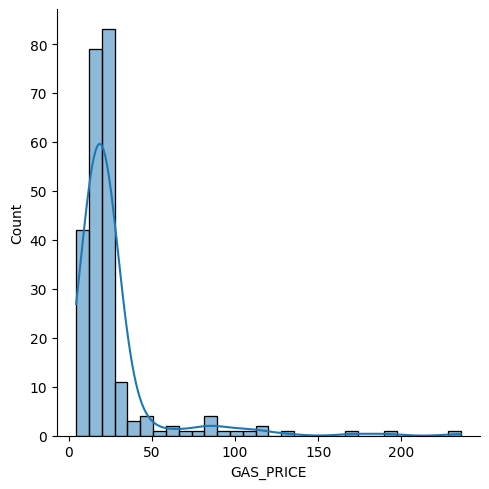

In [19]:
sns.displot(df, x="IP", bins = 30, kde= True)
sns.displot(df, x="GAS_PRICE", bins = 30, kde= True)

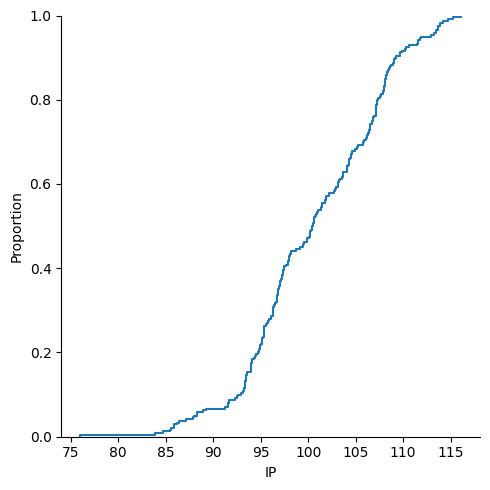

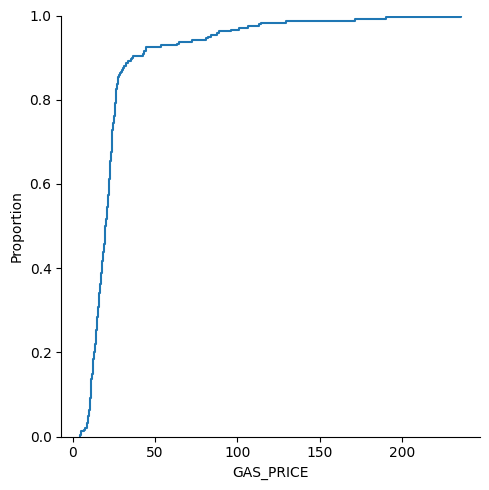

In [20]:
sns.displot(df, x="IP", kind="ecdf")
sns.displot(df, x="GAS_PRICE", kind="ecdf")

### Correlation Analysis

In [21]:
corr1 = stats.pearsonr(df.IP, df.GAS_PRICE)
print(corr1.correlation)
print(corr1.pvalue)
#print(corr.confidence_interval)

0.47161802228369726
1.0762682417224782e-14


## ARIMA Test

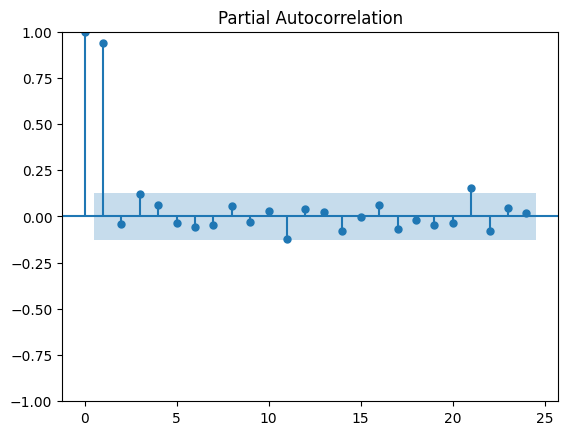

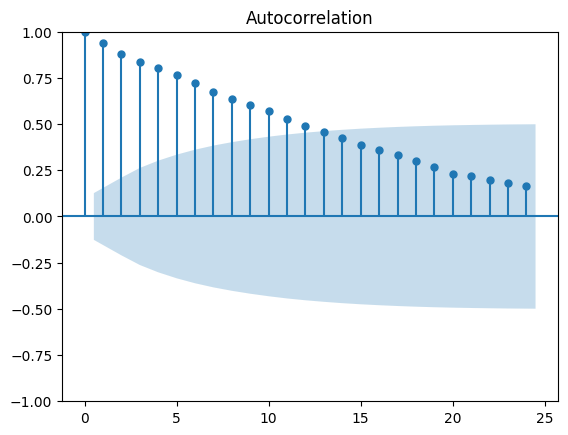

In [22]:
pacf_ip = plot_pacf(df.IP, lags=24)

acf_ip = plot_acf(df.IP, lags=24)

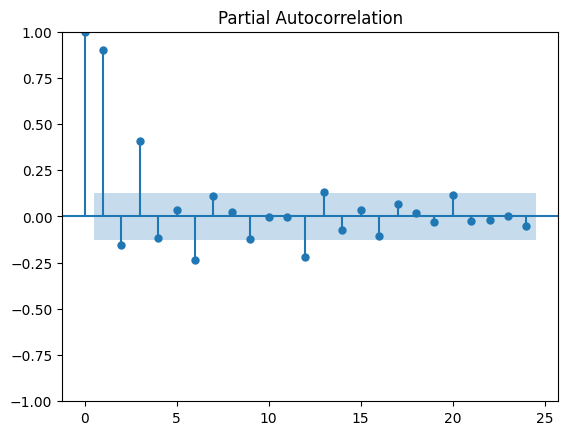

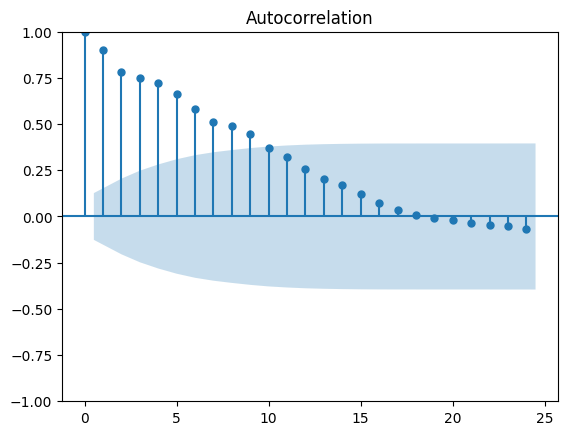

In [23]:
pacf_gp = plot_pacf(df.GAS_PRICE, lags=24)

acf_gp = plot_acf(df.GAS_PRICE, lags=24)

In [24]:
adf_ip = adfuller(df.IP)
print('value',adf_ip[0])
print('p-value',adf_ip[1])

value -1.906419814446655
p-value 0.32904708060949134


In [25]:
adf_gp = adfuller(df.GAS_PRICE)
print('value', adf_gp[0])
print('p-value', adf_gp[1])

value -3.0384825158221362
p-value 0.03145357331650899


In [26]:
# FEATURE ENGINEERING: VARIABILI LAGGATE (IP e GP)

df['IP_t1'] = df.IP.shift(1)
df.IP_t1 = df.IP_t1.fillna(value=92.1)
df['IP_diffed'] = df['IP'] - df['IP_t1'] 

df['GAS_PRICE_t1'] = df.GAS_PRICE.shift(1)
df['GAS_PRICE_t1'] = df['GAS_PRICE_t1'].interpolate(method="nearest", order=3, limit=None, limit_direction='both').ffill().bfill()
df['GAS_PRICE_diffed'] = df['GAS_PRICE'] - df['GAS_PRICE_t1']

df.to_csv(os.path.join(path, "ue27_df.csv"))

In [27]:
corr2 = stats.pearsonr(df.IP, df.IP_t1)
print(corr2.correlation)
print(corr2.pvalue)

0.9524443208536406
7.945390377822594e-125


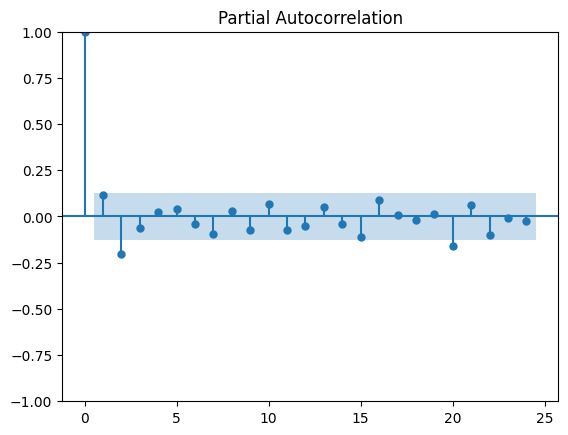

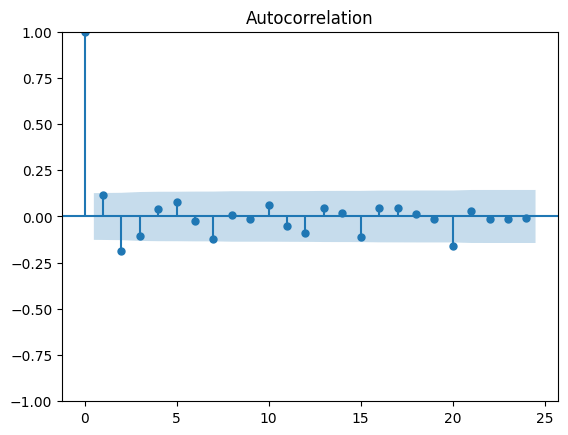

In [92]:
pacf_ipd = plot_pacf(df.IP_diffed, lags=24)

acf_ipd = plot_acf(df.IP_diffed, lags=24)

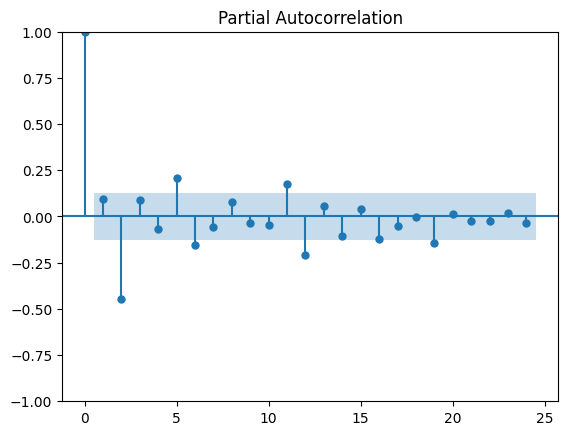

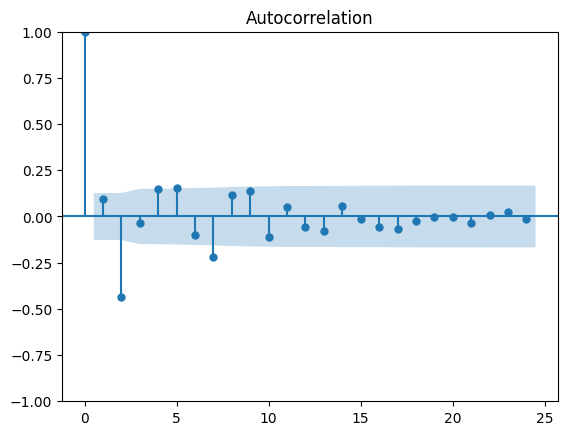

In [93]:
pacf_gpd = plot_pacf(df.GAS_PRICE_diffed, lags=24)

acf_gpd = plot_acf(df.GAS_PRICE_diffed, lags=24)

In [30]:
order_results, warning_orders = fit_arima_models(df['IP'], max_p=2, max_q=2, d=1, iterative=True)

In [31]:
print("Information Criteria for All ARIMA Orders:")
for order, results in order_results.items():
    print(f"ARIMA{order}: AIC = {results['AIC']:.2f}, BIC = {results['BIC']:.2f}, HQIC = {results['HQIC']:.2f}")

Information Criteria for All ARIMA Orders:
ARIMA(0, 1, 0): AIC = 1061.05, BIC = 1064.52, HQIC = 1062.45
ARIMA(0, 1, 1): AIC = 1057.76, BIC = 1064.71, HQIC = 1060.56
ARIMA(0, 1, 2): AIC = 1053.83, BIC = 1064.26, HQIC = 1058.04
ARIMA(1, 1, 0): AIC = 1059.69, BIC = 1066.64, HQIC = 1062.49
ARIMA(1, 1, 1): AIC = 1057.52, BIC = 1067.95, HQIC = 1061.72
ARIMA(1, 1, 2): AIC = 1054.10, BIC = 1068.01, HQIC = 1059.70
ARIMA(2, 1, 0): AIC = 1051.52, BIC = 1061.95, HQIC = 1055.72
ARIMA(2, 1, 1): AIC = 1052.87, BIC = 1066.78, HQIC = 1058.48
ARIMA(2, 1, 2): AIC = 1053.52, BIC = 1070.90, HQIC = 1060.52


In [32]:
best_model, best_rmse = find_best_model(order_results, 'AIC')

Best ARIMA order: (2, 1, 0) with RMSE: 1051.5165966917975


Summary for ARIMA order (2, 1, 0):

                               SARIMAX Results                                
Dep. Variable:                     IP   No. Observations:                  240
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -522.758
Date:                Mon, 20 Jan 2025   AIC                           1051.517
Time:                        06:15:34   BIC                           1061.946
Sample:                             0   HQIC                          1055.719
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      0.026      5.519      0.000       0.094       0.197
ar.L2         -0.2082      0.047     -4.427      0.000      -0.300      -0.116
sigma2         4

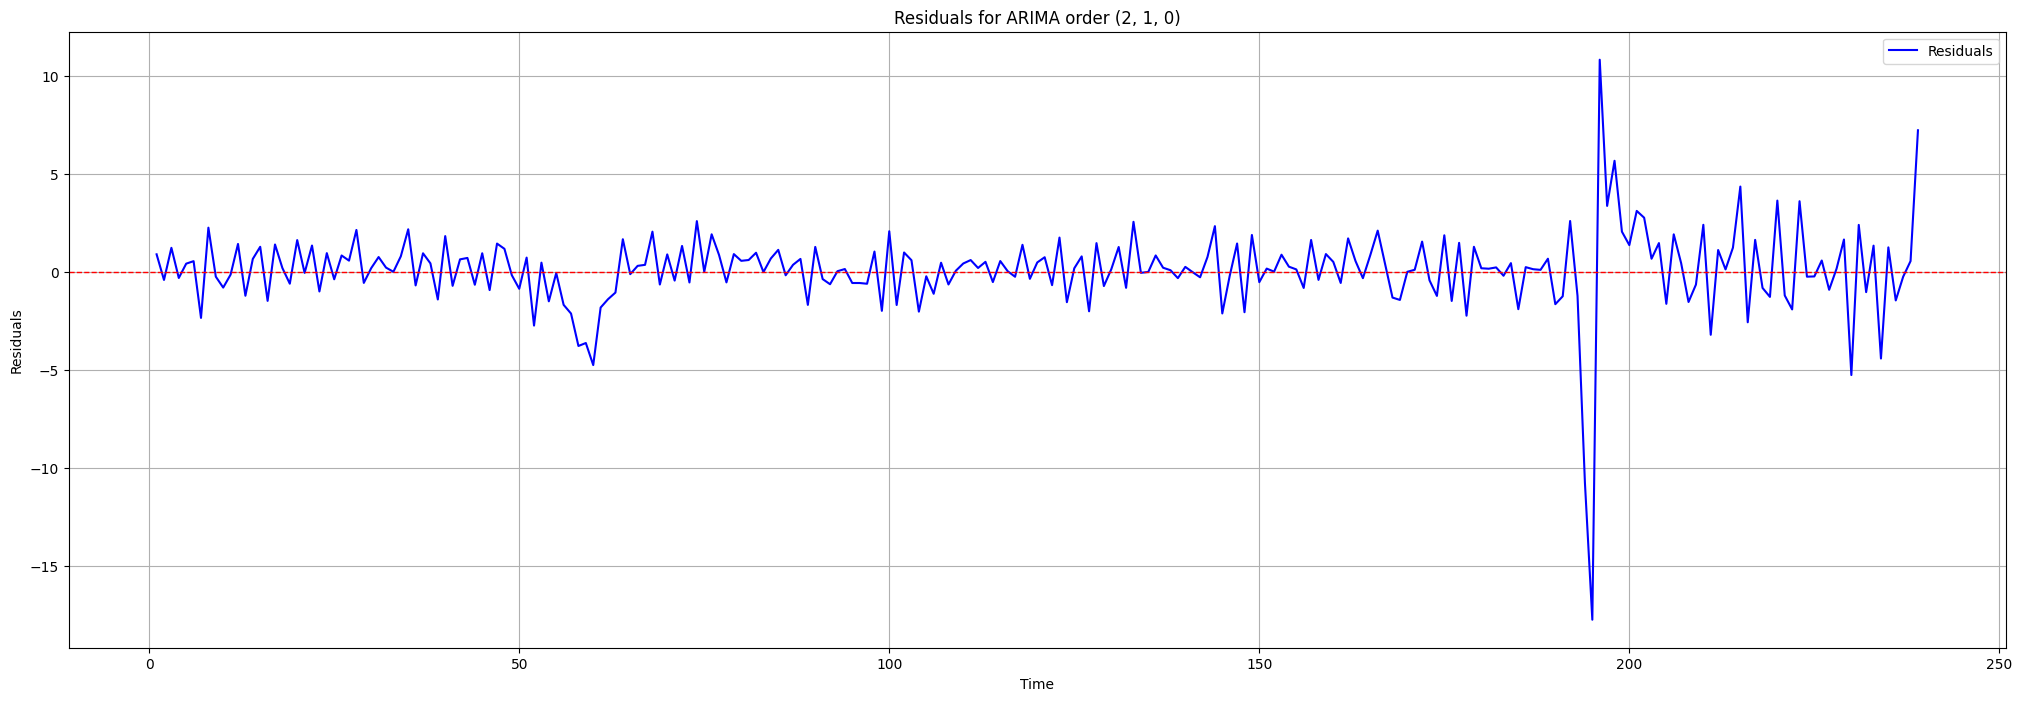

<Figure size 2500x600 with 0 Axes>

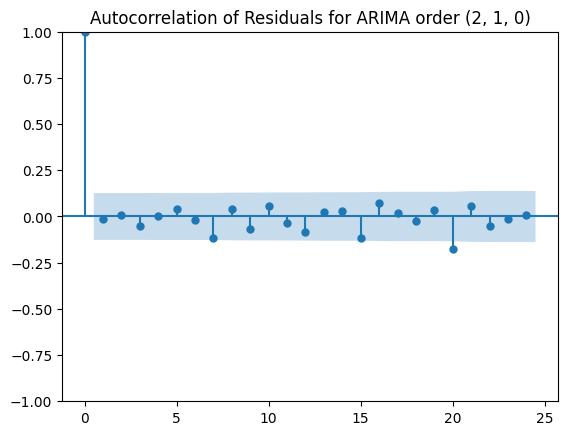

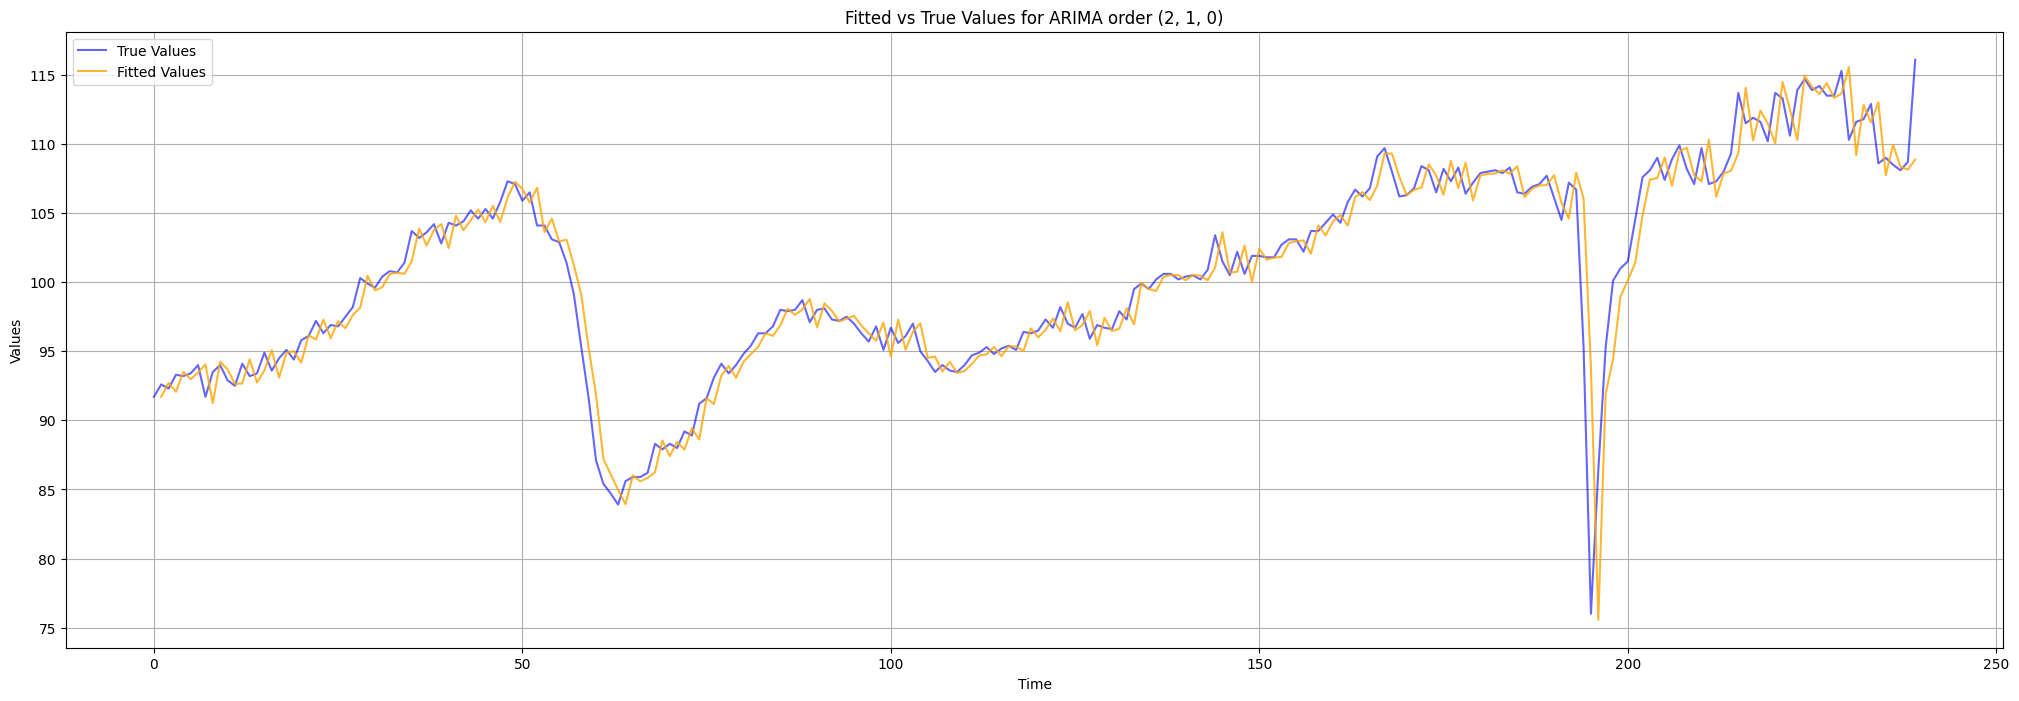

In [33]:
analyze_order((2, 1, 0), order_results)

In [34]:
#analyze_order((0, 1, 0), order_results)

In [35]:
#ljung_box_test((0,1,0), order_results, lags=12)

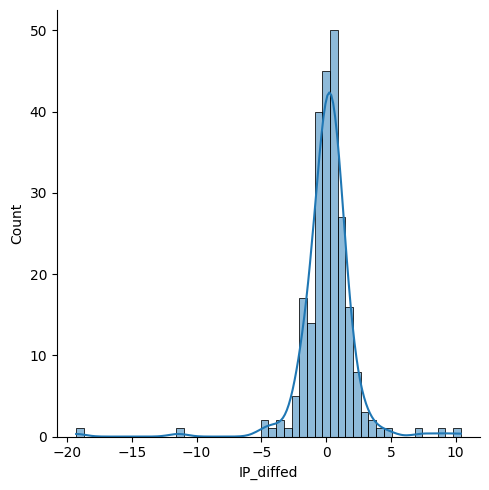

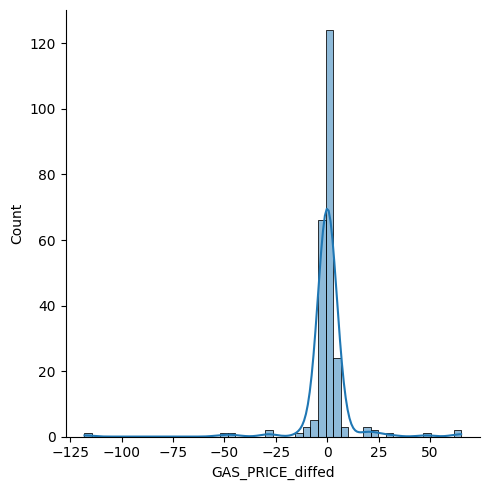

In [36]:
sns.displot(df, x="IP_diffed", bins = 50, kde= True)
sns.displot(df, x="GAS_PRICE_diffed", bins = 50, kde= True)

In [37]:
res = stats.jarque_bera(df['IP'])
print(res.statistic)
print(res.pvalue)

2.0488826979275387
0.3589969634221443


In [38]:
res = stats.jarque_bera(df['GAS_PRICE'])
print(res.statistic)
print(res.pvalue)

6145.376838497788
0.0


In [39]:
ljung_box_test((2,1,0), order_results, lags=12)

Ljung-Box Test Results for ARIMA order (2, 1, 0):


Residuals show no significant autocorrelation (p-value >= 0.05).


,lb_stat,lb_pvalue
1,0.009820,0.921064
2,0.012944,0.993549
3,0.019025,0.999306
4,0.022281,0.999938
5,0.037463,0.999986
6,0.038823,0.999999
7,0.384408,0.999769
8,0.545666,0.999814
9,0.575477,0.999944
10,0.576706,0.999987


In [40]:
# Eseguo il test di Johansen
# Call the jcitest function
j_results = jcitest(df[['IP', 'GAS_PRICE_t1']], det_order=1, k_ar_diff=1)
j_results

{'Eigenvalues': array([0.08483548, 0.05113698]),
 'Eigenvectors': array([[ 0.08127782, -0.18041698],
        [-0.04324333, -0.00455484]]),
 'Trace Test Statistics': array([33.59185524, 12.49281681]),
 'Max Eigenvalue Statistics': array([21.09903843, 12.49281681]),
 'Critical Values (Trace)': array([[16.1619, 18.3985, 23.1485],
        [ 2.7055,  3.8415,  6.6349]]),
 'Critical Values (Max Eigenvalue)': array([[15.0006, 17.1481, 21.7465],
        [ 2.7055,  3.8415,  6.6349]]),
 'P-values (Trace)': array([0.01, 0.01]),
 'P-values (Max Eigenvalue)': array([0.09295993, 0.01      ])}

In [41]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
det_orders = [-1,0,1]
for d in det_orders:
    pyhton_j = coint_johansen(df[['IP', 'GAS_PRICE']], det_order=d, k_ar_diff=1)
    print(f'Johansen Test Results (det_order={pyhton_j})')
    print('Trace Statistics:', pyhton_j.lr1)
    print('Max Eigenvalue Statistics:', pyhton_j.lr2)
    print('Critical Values (Trace):', pyhton_j.cvt)
    print('Critical Values (Max Eigenvalue):', pyhton_j.cvm)
    print('\n')

Johansen Test Results (det_order=<statsmodels.tsa.vector_ar.vecm.JohansenTestResult object at 0x00000216F8358590>)
Trace Statistics: [17.26179605  0.2243644 ]
Max Eigenvalue Statistics: [17.03743166  0.2243644 ]
Critical Values (Trace): [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
Critical Values (Max Eigenvalue): [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


Johansen Test Results (det_order=<statsmodels.tsa.vector_ar.vecm.JohansenTestResult object at 0x00000216FB0E8A50>)
Trace Statistics: [28.98607202  4.98807346]
Max Eigenvalue Statistics: [23.99799856  4.98807346]
Critical Values (Trace): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Critical Values (Max Eigenvalue): [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


Johansen Test Results (det_order=<statsmodels.tsa.vector_ar.vecm.JohansenTestResult object at 0x00000216FB0E8410>)
Trace Statistics: [34.99919656 10.81999734]
Max Eigenvalue Statistics: [24.17919922 10.81999734]
Critical Values (Trace

In [42]:
#import statsmodels.tsa.stattools as ts 
#eg_result=ts.coint(df[['IP']], df[['GAS_PRICE']])
#eg_result

In [43]:
# Applico il test di Engle-Granger
eg_results = egcitest(df[['IP']], df[['GAS_PRICE']], max_lags=1)


Engle-Granger Test Results
OLS Results:
  Coefficients: const        97.420240
GAS_PRICE     0.124085
dtype: float64
  Residual SE: 6.3695

ADF Test on the Residuals:
  Stat: -3.5482
  P-value: 0.0068
  Critical Values:
    1%: -3.4581
    5%: -2.8738
    10%: -2.5733
Conclusion: Cointegrated


In [44]:
#gc_results = gctest(df[['IP', 'GAS_PRICE']], num_lags=1)

## Split dei dati in due dataframe

In [45]:
# Chow test
last_index = int(df[df.Time == '2019-12'].index.values[0])  
first_index = int(df[df.Time == '2020-01'].index.values[0]) 

f_stat, p_value = chow_test(df.GAS_PRICE, df.IP, last_index=last_index, first_index=first_index, significance=0.05)
print(f"F-Statistic: {f_stat}, P-Value: {p_value}")

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 17.064173929692384, P_value: 1.2029262175250466e-07
F-Statistic: 17.064173929692384, P-Value: 1.2029262175250466e-07


In [46]:
#split_date = '2019-12-01 00:00:00'
#
#df_pre = df.loc[df['Time'] <= split_date]
#df_post = df.loc[df['Time'] > split_date]

In [47]:
#j_results_post = jcitest(df_post[['IP', 'GAS_PRICE']], lags=1, alpha=0.05)

In [48]:
#j_results_pre = jcitest(df_pre[['IP', 'GAS_PRICE']], max_lags=1, alphas=0.05)

# GaR Model

In [49]:
from statsmodels.regression.quantile_regression import QuantReg
from src.gar_model import downside_entropy, upside_entropy

In [75]:
# Fit quantile regressions for different quantiles (e.g., 5th, 50th, 95th percentiles)
quantiles = [0.05, 0.5, 0.95]
models = {}
for q in quantiles:
    model = QuantReg(df['IP'], sm.add_constant(df[['IP_t1', 'GAS_PRICE']]))
    result = model.fit(q=q)
    models[q] = result
    print(f"Quantile {q} summary:\n{result.summary()}")

Quantile 0.05 summary:
                         QuantReg Regression Results                          
Dep. Variable:                     IP   Pseudo R-squared:               0.6528
Model:                       QuantReg   Bandwidth:                      0.9239
Method:                 Least Squares   Sparsity:                        19.84
Date:                Mon, 20 Jan 2025   No. Observations:                  240
Time:                        07:01:00   Df Residuals:                      237
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6490      5.280      0.502      0.616      -7.752      13.050
IP_t1          0.9519      0.054     17.590      0.000       0.845       1.059
GAS_PRICE      0.0006      0.018      0.033      0.974      -0.034       0.035

The condition number is larg

In [77]:
# Predict conditional quantiles
df['q_05'] = models[0.05].predict(sm.add_constant(df[['IP_t1', 'GAS_PRICE']]))
df['q_50'] = models[0.5].predict(sm.add_constant(df[['IP_t1', 'GAS_PRICE']]))
df['q_95'] = models[0.95].predict(sm.add_constant(df[['IP_t1', 'GAS_PRICE']]))

In [89]:
# Obtain residuals
df['residuals'] = df['IP'] - df['q_50']

In [95]:
# Ljung-Box Q-test for higher order autocorrelation
lags = 10  # Number of lags to test
lb_stat, lb_p_value = q_stat(acf(df['residuals'], nlags=lags, fft=False)[1:], len(df))
print(f"Ljung-Box test p-values: {lb_p_value}")

Ljung-Box test p-values: [0.06679392 0.0033472  0.00275552 0.00566659 0.00617668 0.01195438
 0.00608381 0.01117221 0.01884638 0.02114826]


In [78]:
# Example: Fit a skewed t-distribution to the predicted quantiles
#mu = df['q_50']  # Median as location
#sigma = (df['q_95'] - df['q_05']) / 2  # Scale based on interquantile range
alpha = 0  # No skewness (symmetric t-distribution)
nu = 30  # Degrees of freedom 
#median = mu  # Median of the conditional distribution
#mu_g = df['IP'].median()  # Mean of the unconditional distribution
#sigma_g = df['IP'].std()  # Std of the unconditional distribution

In [ ]:
# Compute entropies for all rows
downside_entropies = []
upside_entropies = []
for _, row in df.iterrows():
    mu = row['q_50']
    sigma = (row['q_95'] - row['q_05']) / 2
    median = mu
    mu_g = df['IP'].median()  # Mean of the unconditional distribution
    sigma_g = df['IP'].std()  # Std of the unconditional distribution
    downside = downside_entropy(mu, sigma, alpha, nu, mu_g, sigma_g, median)
    upside = upside_entropy(mu, sigma, alpha, nu, mu_g, sigma_g, median)
    downside_entropies.append(downside)
    upside_entropies.append(upside)

# Add to DataFrame
df['downside_entropy'] = downside_entropies
df['upside_entropy'] = upside_entropies

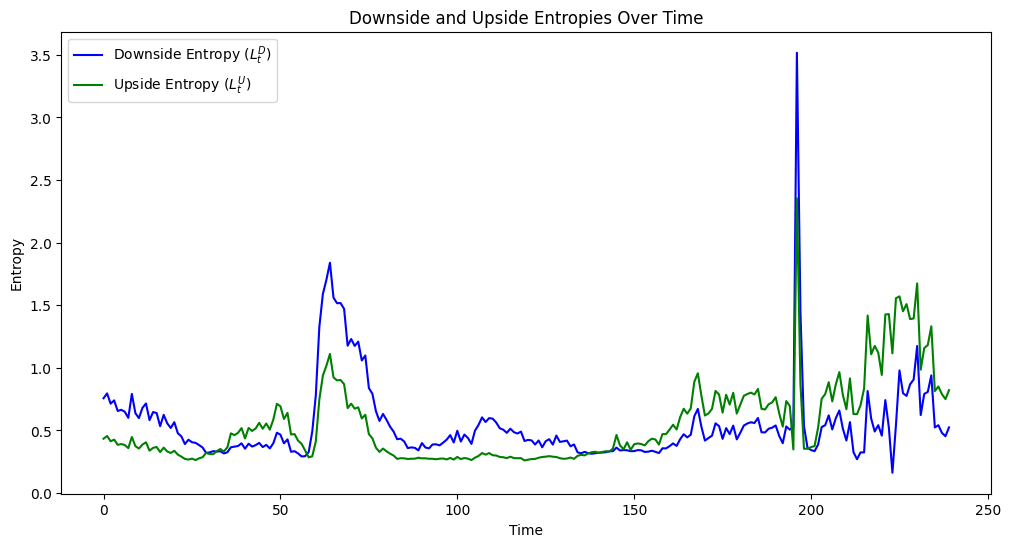

In [80]:
# Plot entropies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['downside_entropy'], label='Downside Entropy ($L_t^D$)', color='blue')
plt.plot(df.index, df['upside_entropy'], label='Upside Entropy ($L_t^U$)', color='green')
plt.title('Downside and Upside Entropies Over Time')
plt.xlabel('Time')
plt.ylabel('Entropy')
plt.legend()
plt.show()

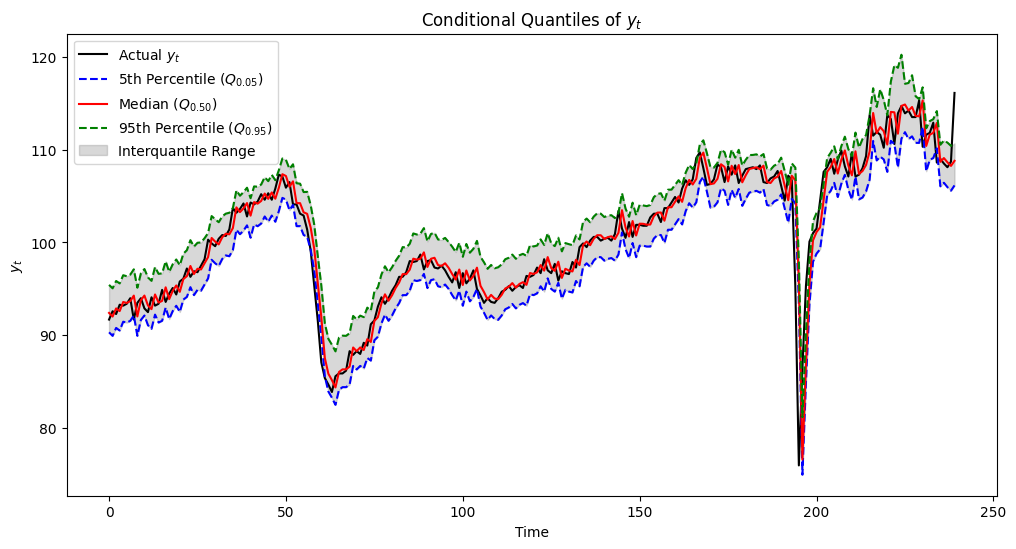

In [81]:
# Plot actual values and predicted quantiles
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IP'], label='Actual $y_t$', color='black')
plt.plot(df.index, df['q_05'], label='5th Percentile ($Q_{0.05}$)', linestyle='--', color='blue')
plt.plot(df.index, df['q_50'], label='Median ($Q_{0.50}$)', linestyle='-', color='red')
plt.plot(df.index, df['q_95'], label='95th Percentile ($Q_{0.95}$)', linestyle='--', color='green')
plt.fill_between(df.index, df['q_05'], df['q_95'], color='gray', alpha=0.3, label='Interquantile Range')
plt.title('Conditional Quantiles of $y_t$')
plt.xlabel('Time')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

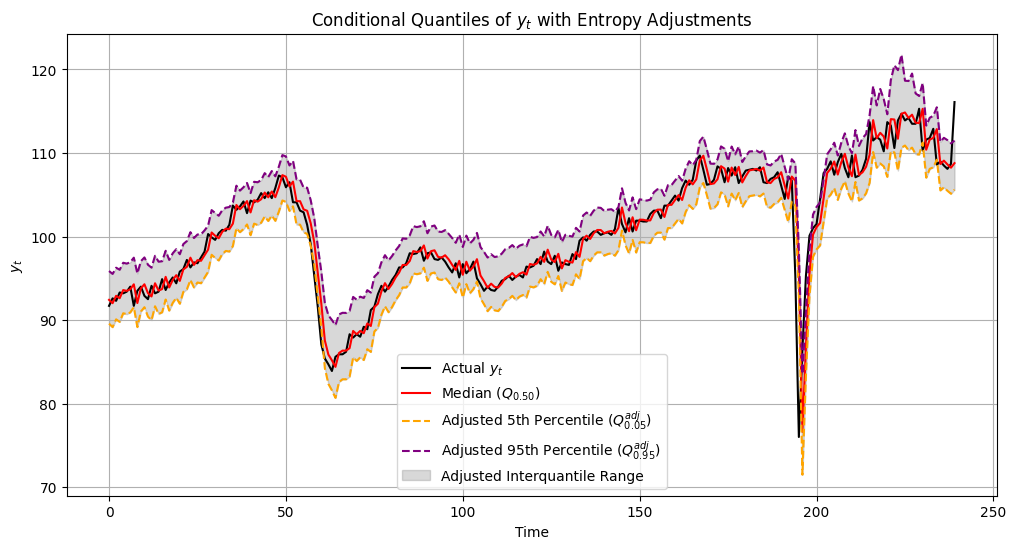

In [85]:
# Scaling factor to control the effect of entropy on quantiles
lambda_factor = lambda_factor = 1  # Tune this value as needed

# Adjust quantiles using entropy values
df['q_05_adjusted'] = df['q_05'] - lambda_factor * df['downside_entropy']
df['q_95_adjusted'] = df['q_95'] + lambda_factor * df['upside_entropy']

# Plot actual values and adjusted quantiles
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IP'], label='Actual $y_t$', color='black')
#plt.plot(df.index, df['q_05'], label='Original 5th Percentile ($Q_{0.05}$)', linestyle='--', color='blue')
#plt.plot(df.index, df['q_95'], label='Original 95th Percentile ($Q_{0.95}$)', linestyle='--', color='green')

# Plot adjusted quantiles
plt.plot(df.index, df['q_50'], label='Median ($Q_{0.50}$)', linestyle='-', color='red')
plt.plot(df.index, df['q_05_adjusted'], label='Adjusted 5th Percentile ($Q_{0.05}^{adj}$)', linestyle='--', color='orange')
plt.plot(df.index, df['q_95_adjusted'], label='Adjusted 95th Percentile ($Q_{0.95}^{adj}$)', linestyle='--', color='purple')

# Fill areas to show quantile range
plt.fill_between(df.index, df['q_05_adjusted'], df['q_95_adjusted'], color='gray', alpha=0.3, label='Adjusted Interquantile Range')

plt.title('Conditional Quantiles of $y_t$ with Entropy Adjustments')
plt.xlabel('Time')
plt.ylabel('$y_t$')
plt.legend()
plt.grid()
plt.show()

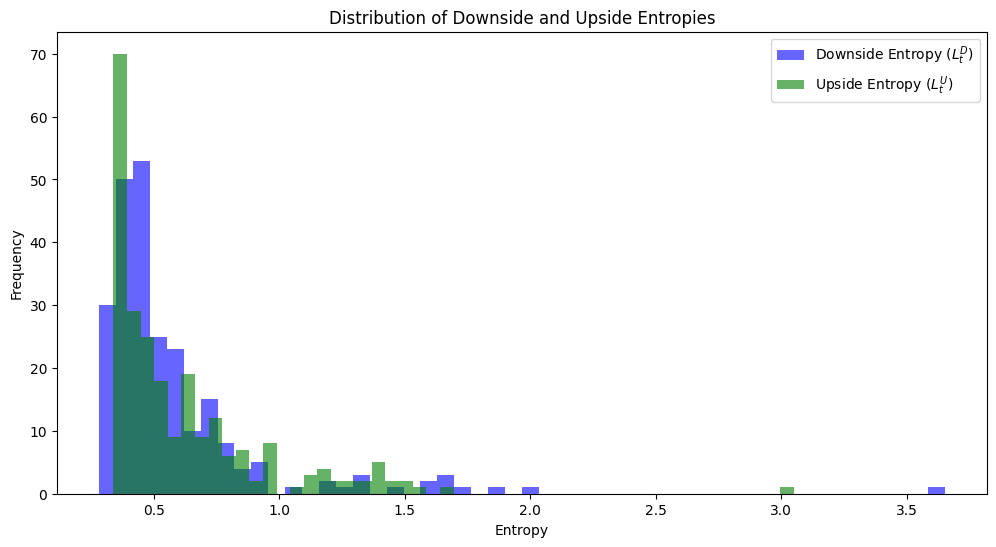

In [55]:
plt.figure(figsize=(12, 6))
plt.hist(df['downside_entropy'], bins=50, alpha=0.6, label='Downside Entropy ($L_t^D$)', color='blue')
plt.hist(df['upside_entropy'], bins=50, alpha=0.6, label='Upside Entropy ($L_t^U$)', color='green')
plt.title('Distribution of Downside and Upside Entropies')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

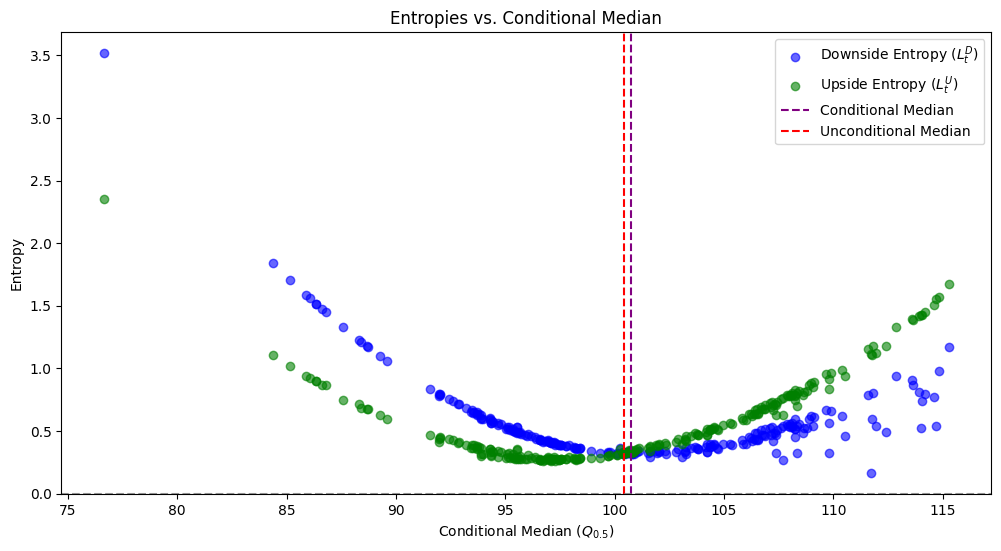

In [103]:
unconditional_median = df['IP'].median()
df['unconditional_median'] = unconditional_median
conditional_median = df['q_50'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(df['q_50'], df['downside_entropy'], label='Downside Entropy ($L_t^D$)', color='blue', alpha=0.6)
plt.scatter(df['q_50'], df['upside_entropy'], label='Upside Entropy ($L_t^U$)', color='green', alpha=0.6)
# Add a red point at the unconditional mean of response
plt.axvline(conditional_median, color='purple', linestyle='--', label='Conditional Median')
plt.axvline(unconditional_median,  color='red', linestyle='--', label='Unconditional Median')
plt.title('Entropies vs. Conditional Median')
plt.xlabel('Conditional Median ($Q_{0.5}$)')
plt.ylabel('Entropy')
plt.axhline(0, linestyle='--', color='gray', alpha=0.8)
plt.legend()
plt.show()

- factor model
- midas
- BART
- sparse group quantile midas?